# HW04: Calibration of models.

* Author: alberto.suarez@uam.es
* Student 1: Gorka Crespo Bravo
* Student 2: Miguel Cuesta Altable
* Student 3: Antón Salvadores Muñiz


Please use latex for the derivations. Alternatively, insert a scanned image of the derivations, as it is here done with the Alan Turing [https://www.turing.org.uk/] picture.


![alt text](alan-turing.jpg "Alan Turing")

In [96]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import Anton_Salvadores_Muniz_my_option_pricing as pricing

import scipy.stats as stats

from scipy.stats import norm, lognorm
from numpy.random import default_rng

from pandas.plotting import autocorrelation_plot
from scipy.stats import norm, probplot
from scipy.optimize import minimize

from tools_qfb import compare_histogram_pdf, qqplot
from stochastic_processes import simulate_geometric_brownian_motion
from my_time_series_MIGUEL import (
    simulate_AR,
    residuals_AR,
    fit_AR_LS,
    fit_AR_ML_gaussian_noise,
    fit_AR_ML_gaussian_noise_SLSQP,
    fit_AR_ML_student_t_noise,
    fit_AR_ML_student_t_noise_SLSQP,
    simulate_ARMA_GARCH,
    residuals_ARMA_GARCH,
    fit_AR_GARCH_ML_gaussian_noise,
    fit_AR_GARCH_ML_gaussian_noise_SLSQP,
    fit_AR_GARCH_ML_student_t_noise,
    fit_AR_GARCH_ML_student_t_noise_SLSQP,
    tests_gaussian_white_noise,
    t_transient,
)

from model_calibration import fit_pdf_ML, fit_pdf_ML_SLSQP

from scipy.stats import skew, kurtosis

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
'''
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import MiguelCuesta_my_option_pricing as pricing

import scipy.stats as stats

from scipy.stats import norm, lognorm
from numpy.random import default_rng

from pandas.plotting import autocorrelation_plot
from scipy.stats import norm, probplot, skew, kurtosis
from scipy.optimize import minimize

from MiguelCuesta_tools_qfb import compare_histogram_pdf, qqplot
from my_stochastic_processes import simulate_geometric_brownian_motion
from my_time_series_MIGUEL import (
    simulate_AR,
    residuals_AR,
    fit_AR_LS,
    fit_AR_ML_gaussian_noise,
    fit_AR_ML_student_t_noise,
    simulate_ARMA_GARCH,
    residuals_ARMA_GARCH,
    fit_AR_GARCH_ML_gaussian_noise,
    fit_AR_GARCH_ML_student_t_noise,
    tests_gaussian_white_noise,
    t_transient,
)

from model_calibration import fit_pdf_ML

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2
'''

'\nimport numpy as np\nimport pandas as pd\n\nimport matplotlib.pyplot as plt\nimport MiguelCuesta_my_option_pricing as pricing\n\nimport scipy.stats as stats\n\nfrom scipy.stats import norm, lognorm\nfrom numpy.random import default_rng\n\nfrom pandas.plotting import autocorrelation_plot\nfrom scipy.stats import norm, probplot, skew, kurtosis\nfrom scipy.optimize import minimize\n\nfrom MiguelCuesta_tools_qfb import compare_histogram_pdf, qqplot\nfrom my_stochastic_processes import simulate_geometric_brownian_motion\nfrom my_time_series_MIGUEL import (\n    simulate_AR,\n    residuals_AR,\n    fit_AR_LS,\n    fit_AR_ML_gaussian_noise,\n    fit_AR_ML_student_t_noise,\n    simulate_ARMA_GARCH,\n    residuals_ARMA_GARCH,\n    fit_AR_GARCH_ML_gaussian_noise,\n    fit_AR_GARCH_ML_student_t_noise,\n    tests_gaussian_white_noise,\n    t_transient,\n)\n\nfrom model_calibration import fit_pdf_ML\n\nimport warnings\nwarnings.filterwarnings("ignore", category=RuntimeWarning)\n\n%load_ext autore

## Exercise 1: AR processes

The evolution of an AR(p) processs is described by a difference equation of order $p$ that is the sum of two terms: a linear model for the deterministic part and additive noise for the stochastic one:
$$
X_t = \phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} + u_t, \quad t = p+1, p+2, \ldots,
$$
where $\left\{u_t \right\}_{t=p+1}^T$ is independent identically distributed noise, which is also independent of $X_{t-\tau}$ for all $\tau > 0$.

To make a simulation of the process one needs $p$ initial conditions $\left\{X_t \right\}_{t=1}^p$.

Note that if the parameters $\phi_0, \boldsymbol{\phi}^T = \left(\phi_1, \phi_2, \ldots, \phi_p\right)$ are known, the value of $X_t$ can be predicted from the past values of the series using the linear model
$$
\hat{X}_t = \phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau}.
$$
The error of this linear predictor is
$$
u_t = X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right).
$$
Since the values $\left\{u_t \right\}_{t=p1}^T $ correspond to the term in $X_t$ that cannot be predicted from the past values of the time series (it is independent of them), they are known as the innovations or the residuals of the model.

Assume that the distribution of the innovations is characterized by a probability density
$$
u_t \sim \text{pdf}\left(u; \boldsymbol{\gamma}\right),
$$
which depends on the vector of parameters $\boldsymbol{\gamma}$.

#### Fit of an AR(p) process: Least squares and maximum likelihood.

Consider a time series
$$
\left\{X_t \right\}_{t=1}^T  = \left(X_1, X_2, \ldots, X_T \right).
$$
We wish to find the parameters of the AR(p) process that best fit these data.
To this end, we can apply two different methods:
1. **Least squares**: The parameters of the deterministic part of the model are obtained by minimizing the mean squared error.
$$
\begin{eqnarray}
\phi_0^{[LS]}, \boldsymbol{\phi}^{[LS]}
& = & \arg  \min_{\phi_0, \boldsymbol{\phi}} \left[ \frac{1}{T-p} \sum_{t=p+1}^T u_t^2 \right] \\
& = & \arg  \min_{\phi_0, \boldsymbol{\phi}} \left[ \frac{1}{T-p} \sum_{t=p+1}^T \left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right) \right)^2 \right].
\end{eqnarray}
$$

2. **Maximum likelihood**: The parameters are determined by maximizing the likelihood of the model given the data.
$$
\phi_0^{[ML]}, \boldsymbol{\phi}^{[ML]}, \boldsymbol{\gamma}^{[ML]}  = \arg  \min_{\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}} \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right),
$$
The likelihood function is the probability of having observed the data, assuming that the model is known
$$
\begin{eqnarray}
\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)
& = & \text{P}\left(\left. \left\{X_t \right\}_{t=p+1}^T \right| \left\{X_{\tau}\right\}_{\tau=1}^p, \phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}\right) \\
& = & \prod_{t=p+1}^T \text{P}\left(\left. X_t \right| \left\{X_{t-\tau}\right\}_{\tau=1}^p, \phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma} \right) =  \prod_{t=p+1}^T \text{pdf}\left(u_t; \boldsymbol{\gamma} \right).
\end{eqnarray}
$$
The probability density $\text{P}\left(\left. \left\{X_t \right\}_{t=p+1}^T \right| \left\{X_{\tau}\right\}_{\tau=1}^p, \phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}\right)$ factorizes because
$$
u_t = X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right).
$$
is independent identically distributed (iid) noise that is also independent of the past values of the series.

#### Exercise 1.1: Minimization of minus the log-likelihood.

Show that maximizing the likelihood is equivalent to minimizing
$$
\text{minus-}\mathcal{LL}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)
= - \log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right) \right),
$$
or any postive constant times this quantity.

Trataremos de ver lo siguiente,

$\boldsymbol{\hat{\gamma}}$ máximo de $\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right) ⇔$

$\boldsymbol{\hat{\gamma}}$ mínimo de $- \log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)\right)$.

Veamos la primera implicación:

$"⇒"$:

Que $\boldsymbol{\hat{\gamma}}$ sea máximo de $\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)$ implica que $\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right) \geq \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)$, $∀ \boldsymbol{\tilde{\gamma}}$.

Por tanto, como la función logarítmica está definida en $\left(0,+\infty\right)$ y es creciente $\left(f(x) = \log{x}  ⇒ f'(x) = \frac{1}{x} > 0, ∀x>0 \right)$, se tiene que

$$
\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right) \geq \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right) ⇒ \\
\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \geq  \log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) ⇒ \\
-\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \leq  -\log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) ∀ \boldsymbol{\tilde{\gamma}}.
$$

Por tanto, se tiene que $\boldsymbol{\hat{\gamma}}$ es el mínimo de $-\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right)$ como queríamos ver.

Veamos ahora la implicación en la otra dirección:

$"⇐"$:

Siguiendo con el razonamiento anterior, que $\boldsymbol{\hat{\gamma}}$ sea mínimo de $-\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)\right)$ implica que $-\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \leq -\log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) ∀ \boldsymbol{\tilde{\gamma}}$.

Ahora bien, teniendo en cuenta que la función exponencial es creciente $\left(f(x) = e^{x}  ⇒ f'(x) = e^{x} > 0, ∀x ∈ \mathbb{R} \right)$, obtenemos:

$$
-\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \leq -\log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) ⇒ \\
\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \geq \log \left( \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right)\right) \Rightarrow \\
\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\hat{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right) \geq \mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\tilde{\gamma}}; \left\{X_t \right\}_{t=1}^T  \right) ∀ \boldsymbol{\tilde{\gamma}},
$$
o lo que es lo mismo, ${\hat{\gamma}}$ es el máximo de la función de verosimilitud, como queríamos comprobar.

Si multiplicamos estas desigualdades por cualquier constante positiva es trivial que se siguen cumpliendo las desigualdades anteriores y por tanto quedaría probada la equivalencia anterior.

#### Exercise 1.2: Relation between maximum likelihood and least squares.
Assume a Gaussian model for the noise
$$
u_t \sim \mathcal{N} \left(0, \sigma \right), \quad t = p+1, p+2, \ldots, T.
$$
For this case,
1. Determine the relationship between the parameters $\phi_0^{[LS]}, \boldsymbol{\phi}^{[LS]}$ and $\phi_0^{[ML]}, \boldsymbol{\phi}^{[ML]}$.
<u>Hint</u>: The simulations in the next cells provide an important clue to the answer.

2. How would one estimate the value of $\sigma$ in the method of least squares? Justify your answer.

1. Según el apartado anterior y teniendo en cuenta la distribución de la normal, obtenemos que los parámetros de máxima verosimilitud se obtienen minimizando la función log-verosimilitud:

$$
\phi_0^{[ML]}, \boldsymbol{\phi}^{[ML]} = \arg  \min_{\phi_0, \boldsymbol{\phi}} -\log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right)\right) ⇔ \\
\arg  \min_{\phi_0, \boldsymbol{\phi}} -\log\left(\prod_{t=p+1}^T \frac{1}{\sqrt{2\piσ^2}}e^\frac{{-\left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)\right)}^2}{2\sigma^2}\right) ⇔ \\
\arg  \min_{\phi_0, \boldsymbol{\phi}} - \sum_{t=p+1}^T\left( \log \left(\frac{1}{\sqrt{2\piσ^2}}\right) + \log \left(e^\frac{{-\left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)\right)}^2}{2\sigma^2}\right)\right) ⇔ \\
\arg  \min_{\phi_0, \boldsymbol{\phi}}  \frac{T-p}{2} \log \left(2\piσ^2\right) + \frac{\sum_{t=p+1}^T{\left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)\right)}^2}{2\sigma^2} ⇔ \\
\arg  \min_{\phi_0, \boldsymbol{\phi}} \sum_{t=p+1}^T{\left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)\right)}^2,
$$

donde el último paso es consecuencia de que es la única parte relevante para la minimización de los parámetros. Como mínimos cuadrados ordinarios se sigue de que

$$
\phi_0^{[LS]}, \boldsymbol{\phi}^{[LS]} = \arg  \min_{\phi_0, \boldsymbol{\phi}} \left[ \frac{1}{T-p} \sum_{t=p+1}^T \left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right) \right)^2 \right] ⇔ \\
\arg  \min_{\phi_0, \boldsymbol{\phi}} \left[ \sum_{t=p+1}^T \left(X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right) \right)^2 \right],
$$

llegamos a que en este caso, donde las innovaciones siguen una normal de media cero y varianza homocedástica, la relación entre los parámetros de máxima verosimilitud y de mínimos cuadrados ordinarios es de igualdad, i.e,

$$
\phi_0^{[LS]} = \phi_0^{[ML]}, \boldsymbol{\phi}^{[LS]} = \boldsymbol{\phi}^{[ML]}.
$$

2. Para estimar $σ$ según el método de mínimos cuadrados, normalmente la varianza se estima como la suma de los residuos al cuadrado, pues los residuos de la regresión son la estimación de las perturbaciones de esta.

Sean $\hat{u}_t = X_t - \hat{X}_t = X_t - \left(\phi_0^{[LS]} + \sum_{\tau=1}^p \phi_{τ}^{[ML]} X_{t- \tau} \right)$, entonces, la varianza estimada es
$$
\hat{\sigma}^2 = \frac{1}{T-p} \sum_{\tau=1}^p \hat{u}_t^2,
$$
donde esto se sigue de que así, nuestro estimador de la varianza es un estimador insesgado.

### Simulation of an AR processes.

In [ ]:
# Simulation of an AR(p) process with Gaussian noise.

phi_0, phi, sigma = 0.3, [0.1, -0.8], 0.4
p = len(phi) # order of the autoregressive process.

random_number_generator = default_rng(seed=0).standard_normal

X, _ = simulate_AR(
    np.zeros(p), phi_0, phi, sigma,
    random_number_generator, n_trajectories=1, n_times=1000
)

t_stationary = int(10.0 * t_transient(phi))

X = X[0, t_stationary:] # Single trajectory in the stationary regime.



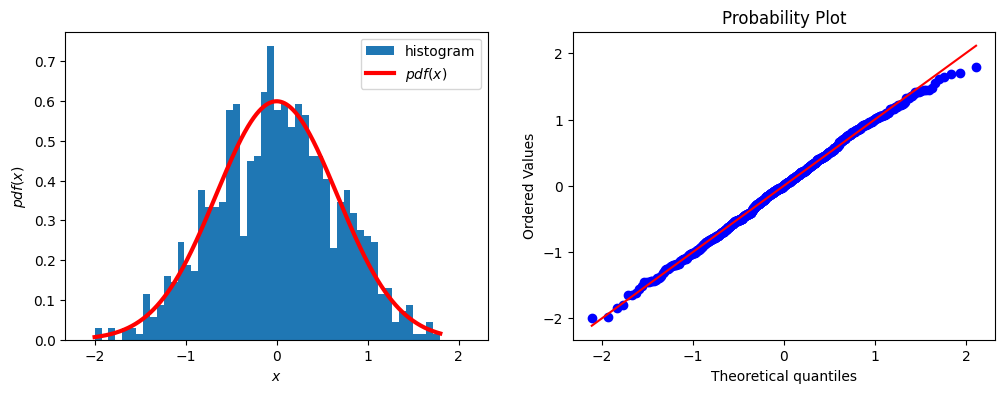

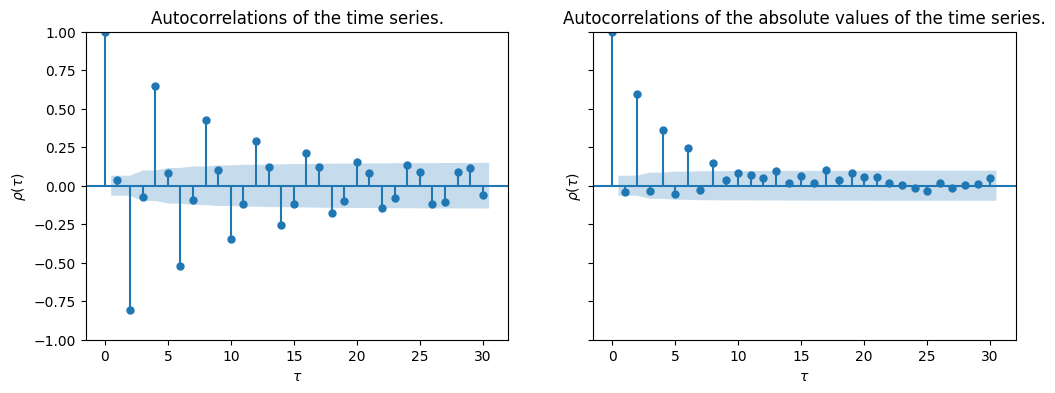

In [ ]:
# The distribution of the values of X_t is Gaussian.
# However, it exhibits linear autocorrelations.

tests_gaussian_white_noise(X - np.mean(X))

#### Least squares fit to an AR process

In [ ]:
# Least squares fit to AR(p) process

phi_0_LS, phi_LS, info_optimization = fit_AR_LS(X, phi_0_seed=0.0,  phi_seed=np.zeros(p))

print('Exact values:')
print(np.round(phi_0, 4), np.round(phi, 4))

print('\nLeast squares estimates:')
print(np.round(phi_0_LS, 4), np.round(phi_LS, 4))

print()
print(info_optimization)

Exact values:
0.3 [ 0.1 -0.8]

Least squares estimates:
0.2813 [ 0.0692 -0.8104]

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.523e-01]
           x: [ 2.813e-01  6.923e-02 -8.104e-01]
        cost: 0.011596662597280092
         jac: [[ 4.284e-06  3.301e-06 -3.893e-06]]
        grad: [ 6.524e-07  5.027e-07 -5.929e-07]
  optimality: 6.524383344931844e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 19
        njev: 13


sigma (least squares)= 0.3902


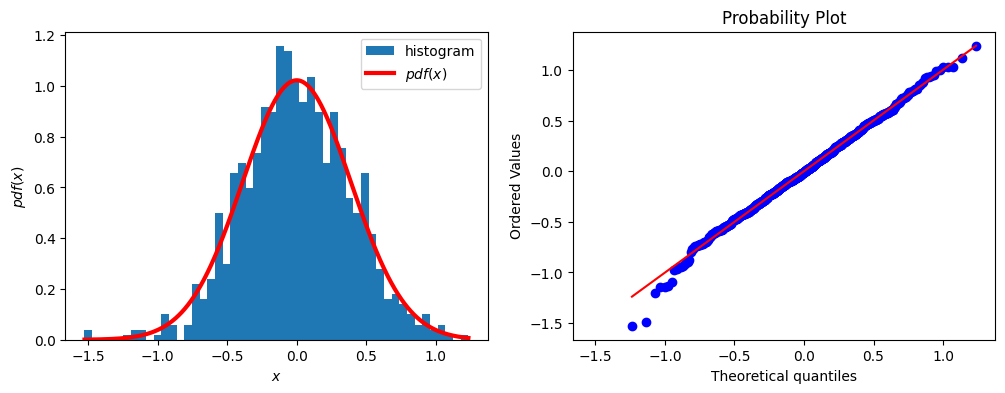

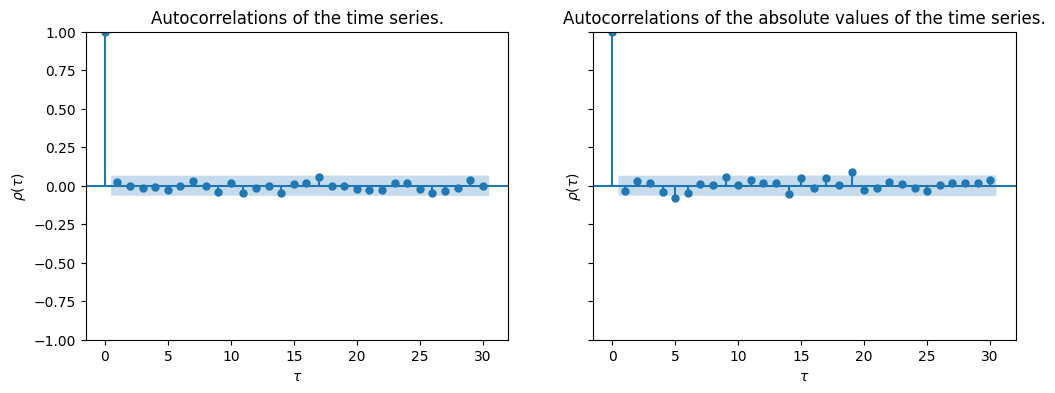

In [ ]:
# The residuals of the AR(p) model are Gaussian white noise.
u = residuals_AR(X, phi_0_LS, phi_LS)
sigma_LS = np.std(u)
print('sigma (least squares)= {:.4f}'.format(sigma_LS))
tests_gaussian_white_noise(u)

#### Maximum likelihood fit to AR process with Gaussian noise


In [ ]:
phi_0_ML, phi_ML, sigma_ML, info_optimization  = fit_AR_ML_gaussian_noise(
    X,
    phi_0_seed=0.0,
    phi_seed=np.zeros(2),
    sigma_seed=1.0,
)

print(np.round(phi_0_ML, 4), np.round(phi_ML, 4), np.round(sigma_ML, 4))

print('Exact values:')
print(np.round(phi_0, 4), np.round(phi, 4), sigma)

print('\nLeast squares estimates:')
print(np.round(phi_0_LS, 4), np.round(phi_LS, 4), np.round(sigma_LS, 4))

print('\nMaximum likelihood estimates:')
print(np.round(phi_0_ML, 4), np.round(phi_ML, 4), np.round(sigma_ML, 4))


print()
print(info_optimization)

0.2813 [ 0.0692 -0.8104] 0.3902
Exact values:
0.3 [ 0.1 -0.8] 0.4

Least squares estimates:
0.2813 [ 0.0692 -0.8104] 0.3902

Maximum likelihood estimates:
0.2813 [ 0.0692 -0.8104] 0.3902

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.4779658459274841
             x: [ 2.813e-01  6.922e-02 -8.104e-01  3.902e-01]
           nit: 399
          nfev: 673
 final_simplex: (array([[ 2.813e-01,  6.922e-02, -8.104e-01,  3.902e-01],
                       [ 2.813e-01,  6.922e-02, -8.104e-01,  3.902e-01],
                       ...,
                       [ 2.813e-01,  6.922e-02, -8.104e-01,  3.902e-01],
                       [ 2.813e-01,  6.922e-02, -8.104e-01,  3.902e-01]]), array([ 4.780e-01,  4.780e-01,  4.780e-01,  4.780e-01,
                        4.780e-01]))


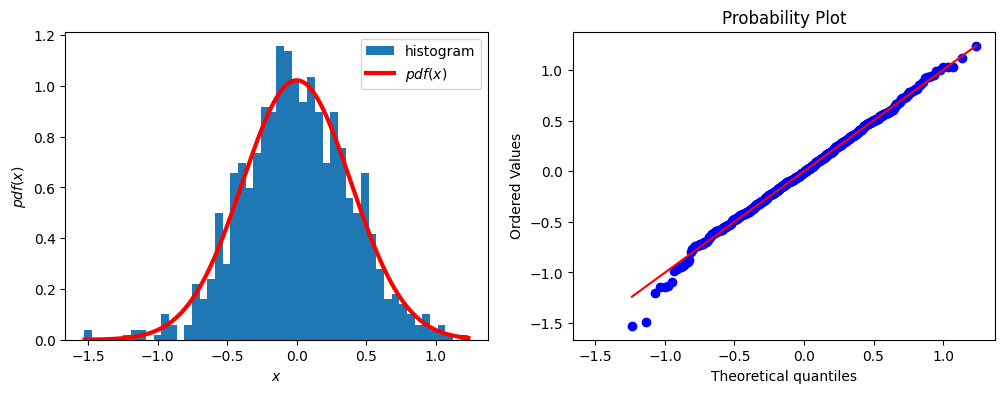

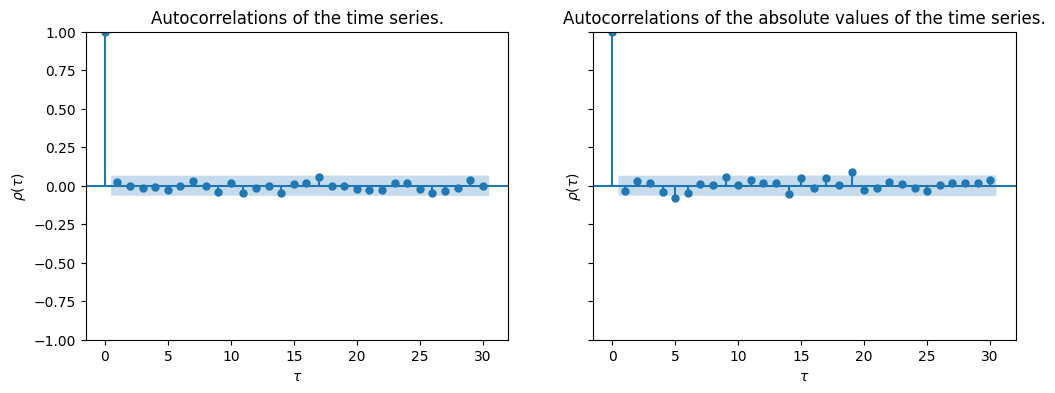

In [ ]:
# The residuals of the AR(p) model are Gaussian white noise.
u = residuals_AR(X, phi_0_ML, phi_ML)
tests_gaussian_white_noise(u)

### Exercise 1.3: Maximum likelihood fit to an AR model with Student's t distribution.

Assume that the noise follows a Student's t distribution of $\nu$ degrees of freedom, centered at $0$, and with a scale parameter $\sigma$.
$$
u_t \sim \text{t.pdf} \left(\nu, 0, \sigma\right).
$$
Note that, in this case, this scale parameter is not the standard deviation.

Design a function to fit an AR model with Student's t noise to the time series $\left(X_1, X_2, \ldots, X_T \right)$.

**The function should be implemented in the file `my_time_series.py`**.

<u>References</u>:
1. https://en.wikipedia.org/wiki/Student%27s_t-distribution
2. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html



$$
\phi_0^{[ML]}, \boldsymbol{\phi}^{[ML]}, \sigma^{[ML]}, \nu^{[ML]}  = \\
 \arg \min_{\phi_0, \boldsymbol{\phi}, \sigma, \nu} - \log \left(\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \sigma, \nu; \left\{X_t \right\}_{t=1}^T  \right)\right) = \\
 \arg \min_{\phi_0, \boldsymbol{\phi}, \sigma, \nu} - \log\left(\prod_{t=p+1}^T
\frac{
    \Gamma\!\bigl(\tfrac{\nu+1}{2}\bigr)
}{
    \Gamma\!\bigl(\tfrac{\nu}{2}\bigr)\,\sqrt{\nu\pi}\,\sigma
}
\left[
    1 + \frac{1}{\nu}\left(\frac{X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)}{\sigma}\right)^2
\right]^{-\tfrac{\nu+1}{2}}
\right) = \\
\arg \min_{\phi_0, \boldsymbol{\phi}, \sigma, \nu}-\,(T-p)\,
\Bigl[
  \log\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)
  -\log\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)
  -\tfrac12\log(\nu\pi)
  -\log\sigma
\Bigr]
\;+\;\tfrac{\nu+1}{2}
\sum_{t=p+1}^T
\log\!\Bigl(
  1 + \tfrac1\nu
  \Bigl(\tfrac{X_t - \bigl(\phi_0 + \sum_{\tau=1}^p \phi_\tau X_{t-\tau}\bigr)}{\sigma}\Bigr)^2
\Bigr) = \\
 \arg \min_{\phi_0, \boldsymbol{\phi}, \sigma, \nu} - \log\left(\prod_{t=p+1}^T
\frac{
    \Gamma\!\bigl(\tfrac{\nu+1}{2}\bigr)
}{
    \Gamma\!\bigl(\tfrac{\nu}{2}\bigr)\,\sqrt{\nu\pi}\,\sigma
}
\left[
    1 + \frac{1}{\nu}\left(\frac{X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right)}{\sigma}\right)^2
\right]^{-\tfrac{\nu+1}{2}}
\right) = \\
\arg \min_{\phi_0, \boldsymbol{\phi}, \sigma, \nu}-\,(T-p)\,
\Bigl[
  \log\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)
  -\log\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)
  -\tfrac12\log(\nu\pi)
  -\log\sigma
\Bigr]
\;+\;\tfrac{\nu+1}{2}
\sum_{t=p+1}^T
\log\!\Bigl(
  1 + \tfrac1\nu
  \Bigl(\tfrac{\hat{u}_t}{\sigma}\Bigr)^2
\Bigr)
$$

In [ ]:
# Simulation of an AR(p) process with Student's t noise.

phi_0, phi, sigma, nu = 0.3, [0.1, -0.8], 0.4, 2.0
p = len(phi) # order of the autoregressive process.

def random_number_generator(size):
    return stats.t.rvs(df=nu, size = size, random_state=default_rng(seed=0))

X, _ = simulate_AR(
    np.zeros(p), phi_0, phi, sigma,
    random_number_generator, n_trajectories=1, n_times=2000
)

t_stationary = int(10.0 * t_transient(phi))

X = X[0, t_stationary:] # Single trajectory.

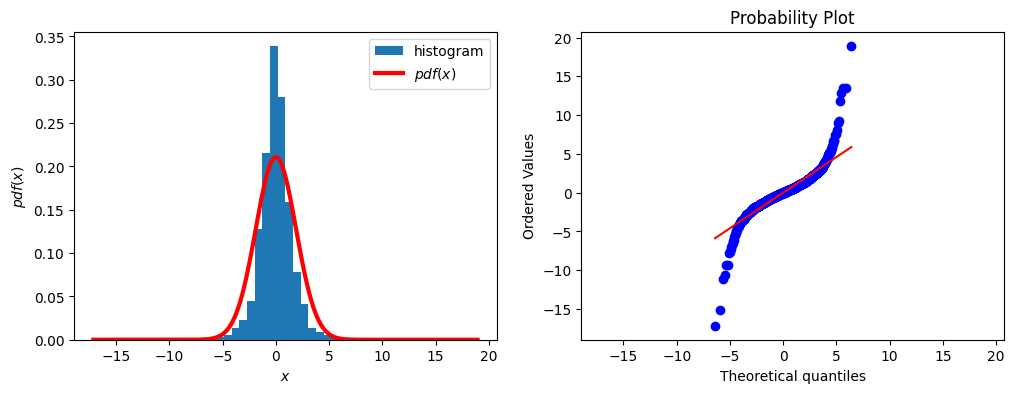

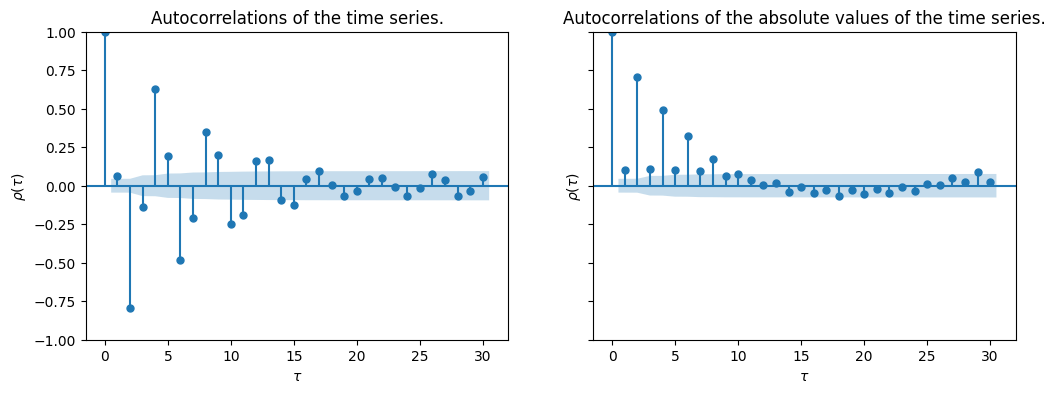

In [ ]:
# The distribution of the values of X_t is not Gaussian.
# It exhibits linear autocorrelations.

tests_gaussian_white_noise(X - np.mean(X))

#### Maximum likelihood fit to AR process with Student's t noise

In [ ]:
phi_0_ML, phi_ML, sigma_ML, nu_ML, info_optimization = fit_AR_ML_student_t_noise(
    X,
    phi_0_seed=0.0,
    phi_seed=np.zeros(2),
    sigma_seed=1.0,
    nu_seed=10.0,
)

/content/my_time_series_MIGUEL.py:356: RuntimeWarning: invalid value encountered in log
  nu = np.exp(np.log(parameters[-1]))


In [ ]:
print('Exact:')
print(
    np.round(phi_0, 4),
    np.round(phi, 4),
    np.round(sigma, 4),
    np.round(nu, 4),
)

print('\nMaximum likelihood estimates:')
print(
    np.round(phi_0_ML, 4),
    np.round(phi_ML, 4),
    np.round(sigma_ML, 4),
    np.round(nu_ML, 4),
)

print()
print(info_optimization)

Exact:
0.3 [ 0.1 -0.8] 0.4 2.0

Maximum likelihood estimates:
0.2722 [ 0.0995 -0.8033] 0.4121 2.1448

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1976.5898967976918
             x: [ 2.722e-01  9.946e-02 -8.033e-01  4.121e-01  2.145e+00]
           nit: 629
          nfev: 1000
 final_simplex: (array([[ 2.722e-01,  9.946e-02, ...,  4.121e-01,
                         2.145e+00],
                       [ 2.723e-01,  9.937e-02, ...,  4.115e-01,
                         2.140e+00],
                       ...,
                       [ 2.722e-01,  9.939e-02, ...,  4.117e-01,
                         2.144e+00],
                       [ 2.726e-01,  9.937e-02, ...,  4.122e-01,
                         2.144e+00]]), array([ 1.977e+03,  1.977e+03,  1.977e+03,  1.977e+03,
                        1.977e+03,  1.977e+03]))


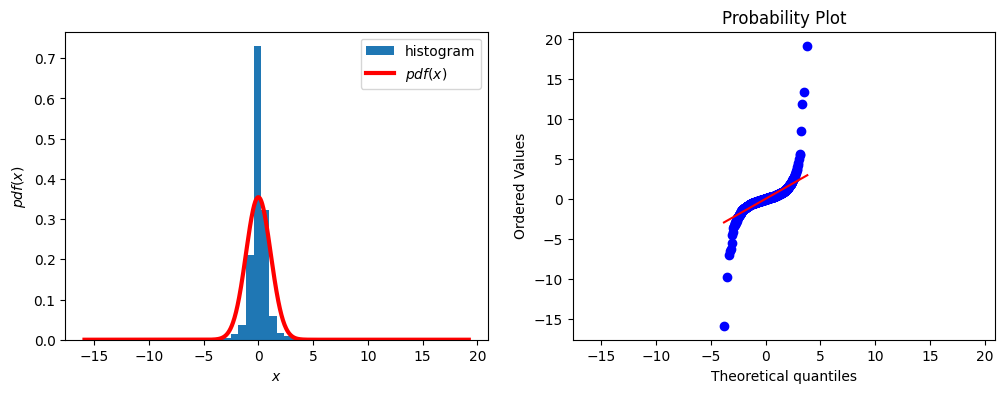

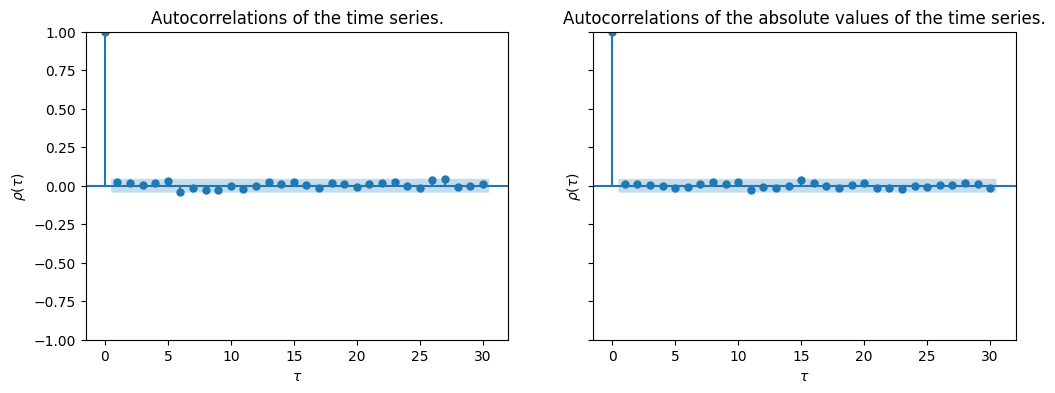

In [ ]:
# The residuals are not normally distributed
u = residuals_AR(X, phi_0_ML, phi_ML)
tests_gaussian_white_noise(u)

<ipython-input-16-692c23c27578>:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, u, ax=axs[1])


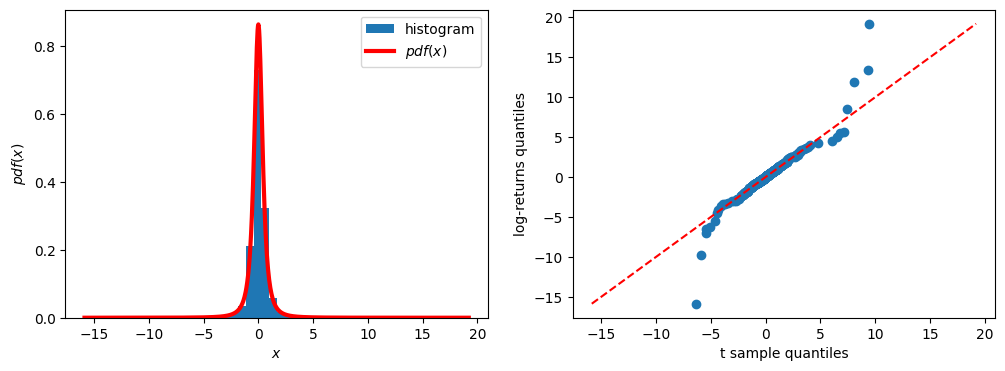

In [ ]:
# The residuals have a Student's t distribution.

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

compare_histogram_pdf(
    u,
    lambda x: stats.t.pdf(x, nu_ML, 0.0, sigma_ML),
    n_bins=50,
    ax=axs[0]
)

rng = default_rng(seed=0)
reference_sample = stats.t.rvs(
    nu_ML, loc=0.0, scale=sigma_ML,
    size=(len(X)), random_state=rng
)

qqplot(reference_sample, u, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')
# The Student's t distribution is very heavy-tailed.
# Therefore, it is normal that deviations appear at the tails in the qqplot.

## Exercise 2: AR(p) + GARCH(r,s) processes



The AR(p) + GARCH(r,s) process is given by the equations
$$
\begin{eqnarray}
X_t & = & \phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} + u_t, \\
u_t & = & \sqrt{h_t} \epsilon_t \\
h_t & = & \kappa
+ \sum_{\tau=1}^r \alpha_{\tau} u_{t- \tau}^2
+ \sum_{\tau=1}^s \beta_{\tau} h_{t- \tau}.
\end{eqnarray}
$$
where $\left\{\epsilon_t \right\}_{t=1}^{\max \left(p,r,s\right)}$ is independent identically distributed (iid) noise, which is also independent of $X_{t-\tau}$ for all $\tau > 0$.

To simulate this process, one needs to specify the initial conditions
$$ \left\{X_t, u_t, h_t \right\}_{t=1}^{\max \left(p,r,s\right)}$$.


### Maximum likelihood fit for an AR(p) + GARCH(r, s) process.

Assume that the distribution of the innovations is modeled by a probability density that, among others, has a location and scale parameters
$$
u_t \sim \text{pdf}\left(u; loc=0.0, scale=\sqrt{h_t}, \boldsymbol{\gamma}\right).
$$
The vector $\boldsymbol{\gamma}$ contains the parameters of the model distribution, other than the location and the scales ones..

Assume that we have a time series
$$
\left\{X_t \right\}_{t=1}^T  = \left(X_1, X_2, \ldots, X_T \right).
$$

For this model the likelihood function to be optimized is
$$
\begin{eqnarray}
\mathcal{L}\left(\phi_0, \boldsymbol{\phi}, \kappa, \boldsymbol{\alpha}, \boldsymbol{\beta},\boldsymbol{\gamma}; \left\{X_t \right\}_{t=1}^T  \right) =
 \prod_{t=\max(p,r,s)+1}^T \text{pdf}\left(u_t; loc=0.0, scale=\sqrt{h_t}, \boldsymbol{\gamma} \right).
\end{eqnarray}
$$
where
$$
u_t = X_t - \left(\phi_0 + \sum_{\tau=1}^p \phi_{\tau} X_{t- \tau} \right), \quad t > \max(p,r,s).
$$
is independent of the past values of the series, and
$$
\epsilon_t = \frac{u_t}{\sqrt{h_t}}, \quad t > \max(p,r,s),
$$
is iid noise.

In [ ]:
# Simulate AR(p) + GARCH(r,s)

phi_0, phi= 0.3, [0.1, 0.3]
p = len(phi) - 1
theta = []
q = len(theta)
kappa = 0.1
alpha = [0.27]
r = len(alpha)
beta = [0.70]
s = len(beta)
delay = max(p, q, r, s)
X_0 = np.ones(delay) * phi[0] / (1.0 -np.sum(phi[1:]))
u_0 = np.zeros(delay)
h_0 = np.ones(delay) * kappa / (1.0 + np.sum(alpha) + np.sum(beta))

random_number_generator = default_rng(seed=0).standard_normal

X, u, h = simulate_ARMA_GARCH(
    X_0, u_0, h_0,
    phi_0, phi, theta, kappa, alpha, beta,
    random_number_generator, n_trajectories=1, n_times=2000
)

t_transient = 100
X = X[0, t_transient:] # Single trajectory.


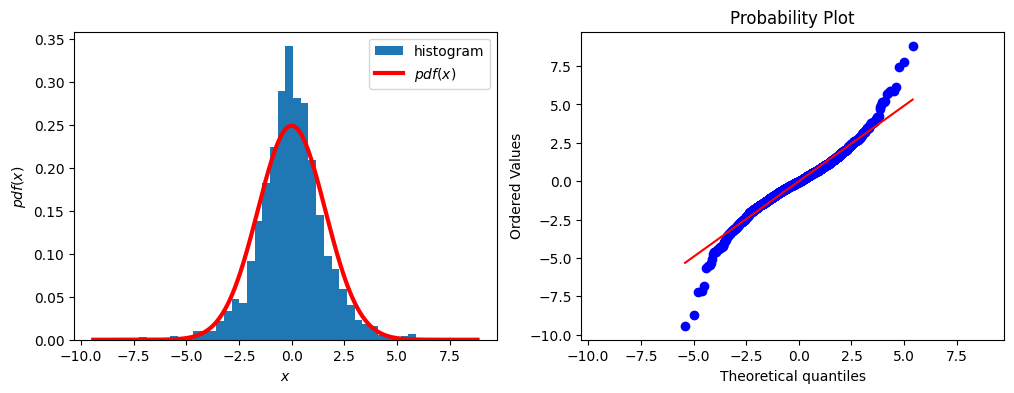

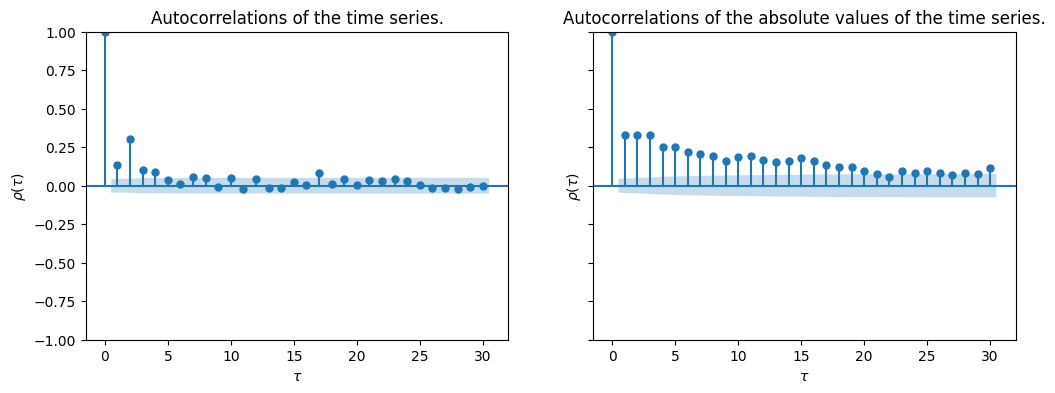

In [ ]:
# The distribution of the values of X_t is leptokurtic (heavy-tailed).
# It exhibits linear autocorrelations.

tests_gaussian_white_noise(X - np.mean(X))

#### Maximum likelihood fit to a AR(p) + GARCH(r,s) process

In [ ]:
phi_0_ML, phi_ML, kappa_ML, alpha_ML, beta_ML, info_optimization = fit_AR_GARCH_ML_gaussian_noise(
    X,
    phi_0_seed=phi_0,
    phi_seed=phi,
    kappa_seed=kappa,
    alpha_seed=alpha,
    beta_seed=beta,
)

/content/my_time_series_MIGUEL.py:414: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))


In [ ]:
print('Exact:')
print(
    np.round(phi_0, 4),
    np.round(phi, 4),
    np.round(kappa, 4),
    np.round(alpha, 4),
    np.round(beta, 4),
)

print('Maximum likelihood estimates:')
print(
    np.round(phi_0_ML, 4),
    np.round(phi_ML, 4),
    np.round(kappa_ML, 4),
    np.round(alpha_ML, 4),
    np.round(beta_ML, 4),
)

print()
print(info_optimization)

Exact:
0.3 [0.1 0.3] 0.1 [0.27] [0.7]
Maximum likelihood estimates:
0.2564 [0.0956 0.2919] 0.066 [0.2185] [0.7592]

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.6705772660580347
             x: [ 2.564e-01  9.565e-02  2.919e-01  6.600e-02  2.185e-01
                  7.592e-01]
           nit: 328
          nfev: 547
 final_simplex: (array([[ 2.564e-01,  9.565e-02, ...,  2.185e-01,
                         7.592e-01],
                       [ 2.564e-01,  9.565e-02, ...,  2.185e-01,
                         7.592e-01],
                       ...,
                       [ 2.564e-01,  9.565e-02, ...,  2.185e-01,
                         7.592e-01],
                       [ 2.564e-01,  9.565e-02, ...,  2.185e-01,
                         7.592e-01]]), array([ 1.671e+00,  1.671e+00,  1.671e+00,  1.671e+00,
                        1.671e+00,  1.671e+00,  1.671e+00]))


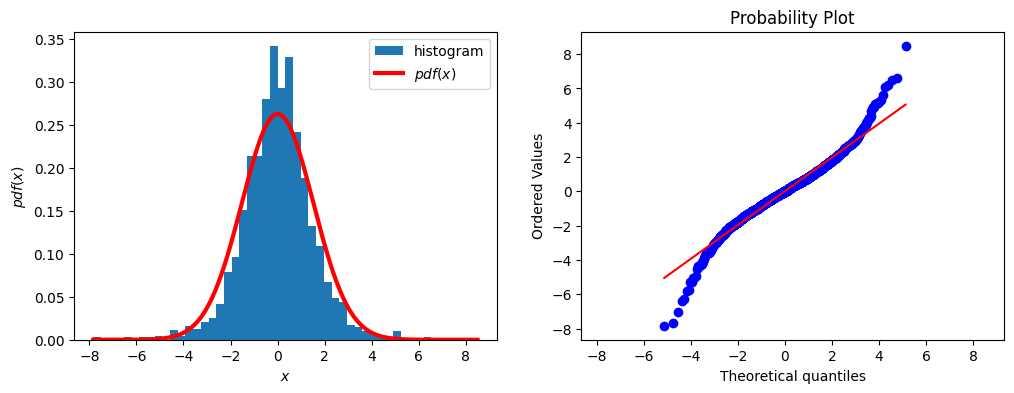

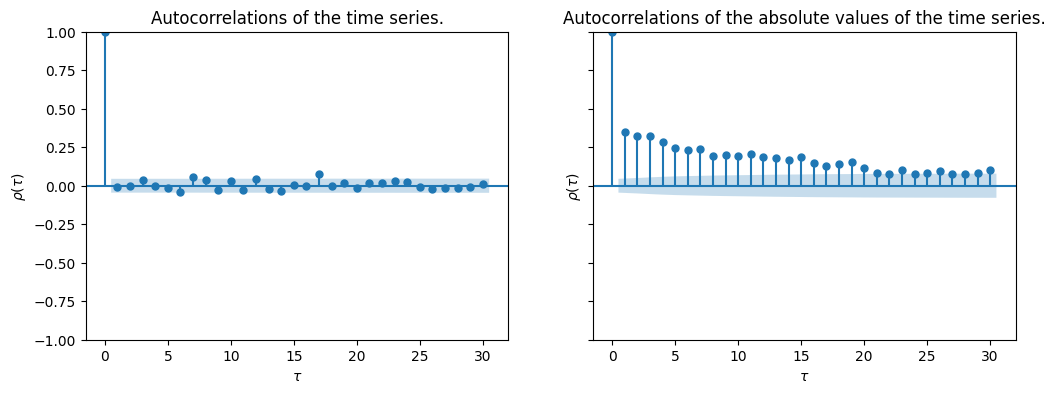

In [ ]:
# The residuals (u) are not Gaussian.
# The residuals (u) are uncorrelated but exhibit non-linear dependence.

u, h = residuals_ARMA_GARCH(
    X,
    phi_0=phi_0_ML,
    phi=phi_ML,
    theta=[],
    kappa=kappa_ML,
    alpha=alpha_ML,
    beta=beta_ML
)

tests_gaussian_white_noise(u)

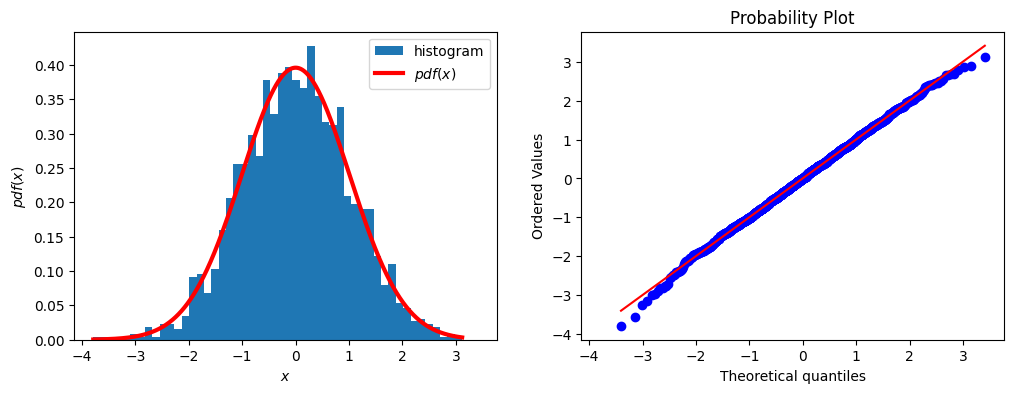

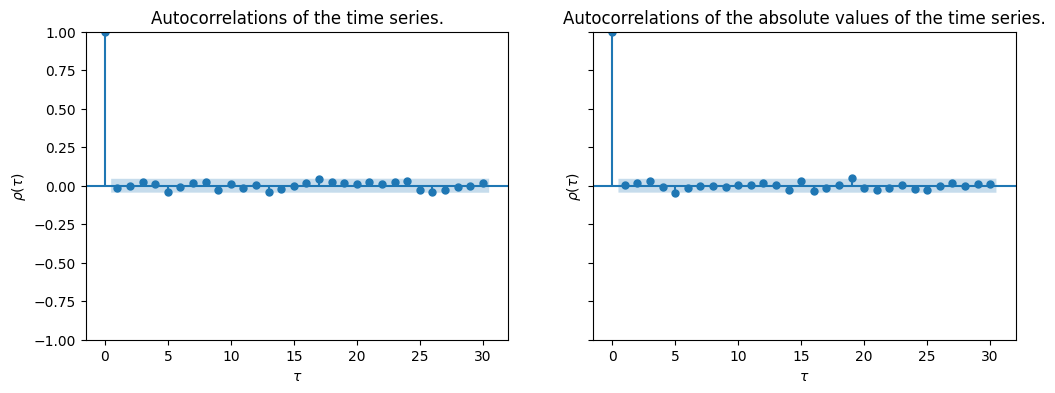

In [ ]:
# The values of epsilon are Gaussian white noise.

epsilon = u / np.sqrt(h)
tests_gaussian_white_noise(epsilon)

### Exercise 2.1: Maximum likelihood fit to an AR+GARCH model with Student's t distribution.

Assume that the innovations
$$
u_t \sim \mathcal{t} \left(\nu, loc=0, scale=\sigma\right)
$$
follow a Student's t distribution of $\nu$ degrees of freedom centered at $0$, whose scale parameter is $\sigma$.

Design a function to fit an AR + GARCH model with Student's t noise to the time series $\left(X_1, X_2, \ldots, X_T \right)$.

**The function should be implemented in the file `my_time_series.py`**.

In [ ]:
phi_0_ML, phi_ML, kappa_ML, alpha_ML, beta_ML, nu_ML, info_optimization = fit_AR_GARCH_ML_student_t_noise(
    X,
    phi_0_seed=phi_0,
    phi_seed=phi,
    kappa_seed=kappa,
    alpha_seed=alpha,
    beta_seed=beta,
    nu_seed=10.0
)

/content/my_time_series_MIGUEL.py:476: RuntimeWarning: invalid value encountered in log
  - gammaln(nu / 2) - 0.5 * np.log(h)


In [ ]:
print('Exact:')
print(
    np.round(phi_0, 4),
    np.round(phi, 4),
    np.round(kappa, 4),
    np.round(alpha, 4),
    np.round(beta, 4),
)

print('Maximum likelihood estimates:')
print(
    np.round(phi_0_ML, 4),
    np.round(phi_ML, 4),
    np.round(kappa_ML, 4),
    np.round(alpha_ML, 4),
    np.round(beta_ML, 4),
)

print()
print(info_optimization)

Exact:
0.3 [0.1 0.3] 0.1 [0.27] [0.7]
Maximum likelihood estimates:
0.2571 [0.0957 0.292 ] 0.0639 [0.2165] [0.7584]

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3173.8976592800873
             x: [ 2.571e-01  9.571e-02  2.920e-01  6.392e-02  2.165e-01
                  7.584e-01  9.421e+01]
           nit: 694
          nfev: 1159
 final_simplex: (array([[ 2.571e-01,  9.571e-02, ...,  7.584e-01,
                         9.421e+01],
                       [ 2.571e-01,  9.571e-02, ...,  7.584e-01,
                         9.421e+01],
                       ...,
                       [ 2.571e-01,  9.571e-02, ...,  7.584e-01,
                         9.421e+01],
                       [ 2.571e-01,  9.571e-02, ...,  7.584e-01,
                         9.421e+01]]), array([ 3.174e+03,  3.174e+03,  3.174e+03,  3.174e+03,
                        3.174e+03,  3.174e+03,  3.174e+03,  3.174e+03]))


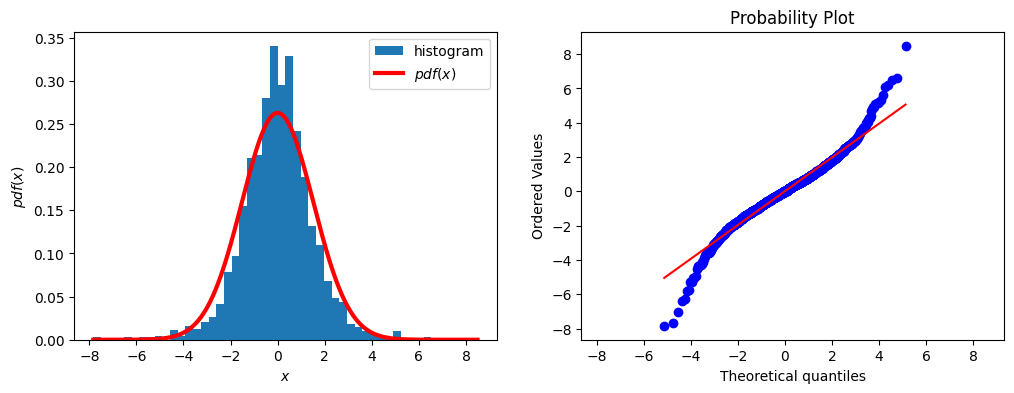

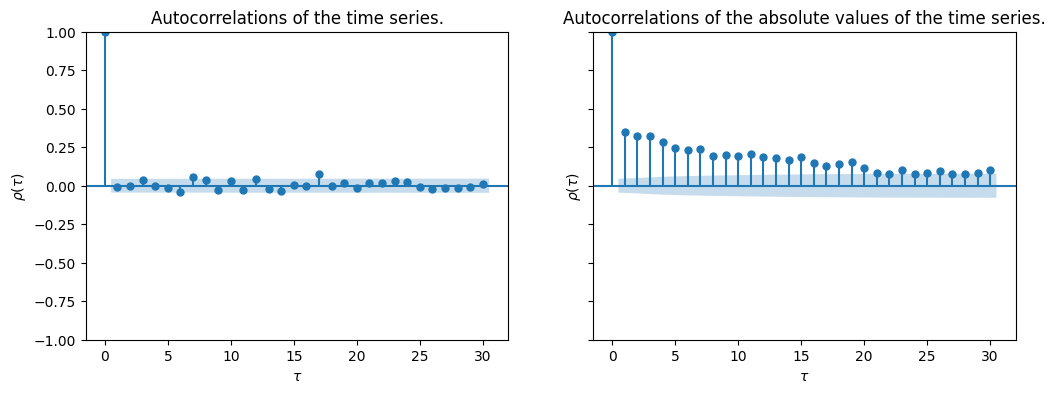

In [ ]:
# The residuals (u) are not Gaussian.
# The residuals (u) are uncorrelated but exhibit non-linear dependence.

u, h = residuals_ARMA_GARCH(
    X,
    phi_0=phi_0_ML,
    phi=phi_ML,
    theta=[],
    kappa=kappa_ML,
    alpha=alpha_ML,
    beta=beta_ML
)

tests_gaussian_white_noise(u)

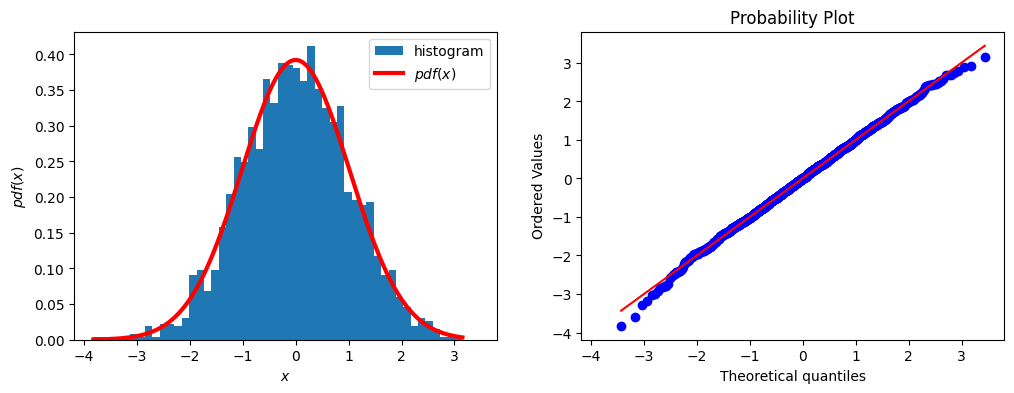

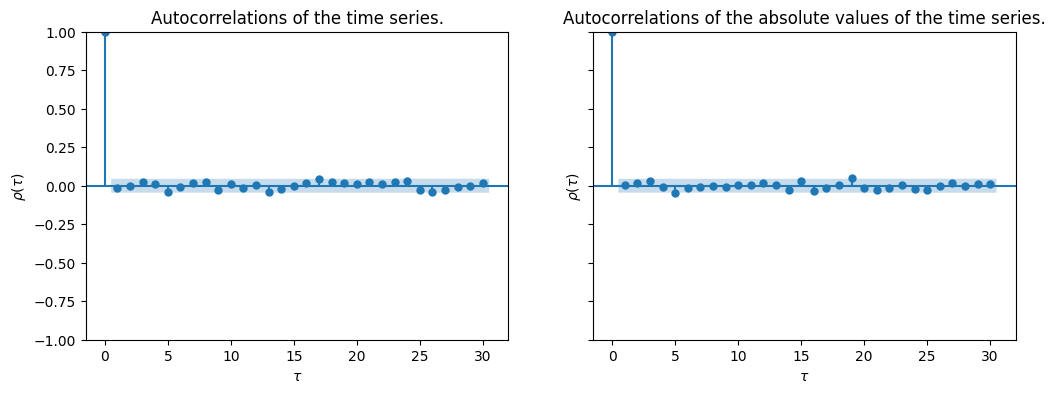

In [ ]:
# The values of epsilon are Gaussian white noise.

epsilon = u / np.sqrt(h)
tests_gaussian_white_noise(epsilon)

## Exercise 3: Models of financial time series
Consider the time series of prices of an asset measured at discrete times
$$
\left\{S_0, S_1, \ldots, S_T \right\}.
$$

The corresponding time series of log-returns is
$$
\left\{X_1, X_2, \ldots, X_{T} \right\}
$$
with $X_t = \log{\frac{S_t}{S_{t-1}}}, \ \ t= 1, 2, \ldots, T$.

Asset returns typically have some common characteristics. It is important to understand the implications of these properties and to identify models that can account for these features.

<u> References:</u>
1. Cont, Rama. (2002). Empirical Properties of Asset Returns: Stylized Facts and Statistical Issues. Quantitative Finance, pp. 223-236. DOI: 10.1088/1469-7688/1/2/304.  [http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf]
2. https://towardsdatascience.com/introduction-to-quantitative-finance-part-i-stylised-facts-of-asset-returns-5190581e40ea

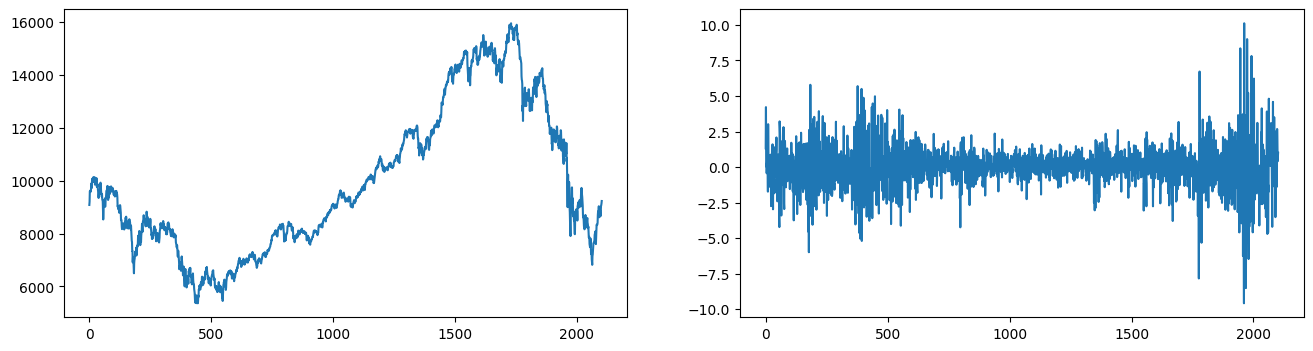

In [ ]:
# Load the time series of prices and store it in a numpy array.
prices = pd.read_csv("ibex35raw.csv")
prices = np.ravel(pd.DataFrame.to_numpy(prices))

# Compute the log-returns.
log_returns = 100.0 * np.log(prices[1:] / prices[:-1]) # equivalent.

# Plot the time series.
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
_ = axs[0].plot(prices)
_ = axs[1].plot(log_returns)

####  Non-Gaussianity (heavy tails, leptokurtic data).

In the Black-Scholes model, it is assumed that the log-returns are iid normal random variables.
Empirically, one observes that the distribution of historical values of the log-returns is heavy-tailed;
that is, the probability of large positive and negative returns is much larger that what a normal model would predict.

In [ ]:
from scipy.stats import skew, kurtosis
print('Statistics of log-returns')
print(
    (
        'Mean = {:.6f}\n'
        + 'Standard deviation (volatility) = {:.4f} \n'
        + 'Variance = {:.4f} \n'
        + 'Asymmetry coefficient = {:.4f} \n'
        + 'Kurtosis = {:.4f} \n'
        + 'Excess kurtosis = {:.4f} \n'
    ).format(
        np.mean(log_returns),
        np.std(log_returns),
        np.var(log_returns),
        skew(log_returns), # 0.0 for distributions that are symetric about the mean.
        kurtosis(log_returns),  # 3.0 for Gaussian.
        kurtosis(log_returns) - 3.0  # 0.0 for Gaussian.
    )
)



Statistics of log-returns
Mean = 0.000773
Standard deviation (volatility) = 1.5067 
Variance = 2.2701 
Asymmetry coefficient = -0.0129 
Kurtosis = 5.2803 
Excess kurtosis = 2.2803 



In [ ]:
# Fit to a normal pdf (maximum likelihood).

mu_0, sigma_0 = 0.0, 1.0 # Initial seed for optimization
(mu_ML, sigma_ML), info_optimization = fit_pdf_ML(
    log_returns, norm.pdf , (mu_0, sigma_0)
)

print('Maximum likelihood: mu = {:.4e}    sigma = {:.4f}'.format(
    mu_ML, sigma_ML))


print()

Maximum likelihood: mu = 7.7329e-04    sigma = 1.5067



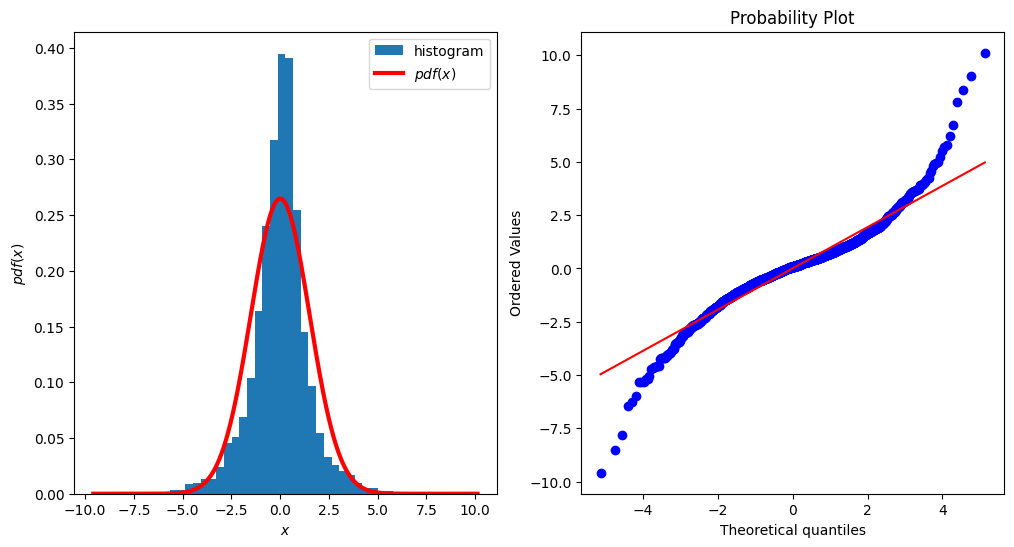

In [ ]:
# are log-returns normally distributed?

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
compare_histogram_pdf(
    log_returns,
    lambda x: norm.pdf(x, mu_ML, sigma_ML),
    ax=axs[0],
)
_ = probplot(log_returns, sparams=(mu_ML, sigma_ML), dist='norm', plot=axs[1])

### ML fit to a student's t distribution (heavier tails than the Gaussian).

In [ ]:
# Fit to a student's t distribution (heavier tails than the Gaussian).

nu_seed, location_seed, scale_seed  = 10.0, 0.0, 1.0 # Initial seed for the optimization.

(nu_ML, location_ML, scale_ML), info_optimization = fit_pdf_ML(
    log_returns, stats.t.pdf, (nu_seed, location_seed, scale_seed)
)

print('Maximum likelihood: location = {:.4e}    scale = {:.4f}, nu = {:.4f}'.format(
    location_ML, scale_ML, nu_ML))


print()
print(info_optimization)

Maximum likelihood: location = 4.2503e-02    scale = 0.9448, nu = 2.9083

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.7283491354372496
             x: [ 2.908e+00  4.250e-02  9.448e-01]
           nit: 156
          nfev: 298
 final_simplex: (array([[ 2.908e+00,  4.250e-02,  9.448e-01],
                       [ 2.908e+00,  4.250e-02,  9.448e-01],
                       [ 2.908e+00,  4.250e-02,  9.448e-01],
                       [ 2.908e+00,  4.250e-02,  9.448e-01]]), array([ 1.728e+00,  1.728e+00,  1.728e+00,  1.728e+00]))


<ipython-input-32-45997270487d>:17: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, log_returns, ax=axs[1])


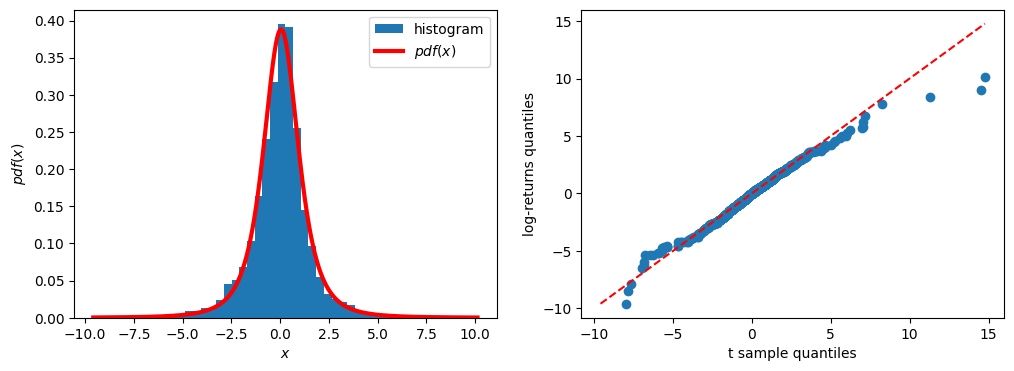

In [ ]:
# Visual test: are log-returns distributed as a Student's t?

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_histogram_pdf(
    log_returns,
    lambda x: stats.t.pdf(x, nu_ML, location_ML, scale_ML),
    n_bins=50,
    ax=axs[0],
)

rng = default_rng(seed=2)
reference_sample = (
    location_ML
    + scale_ML * stats.t.rvs(nu_ML, size=(len(log_returns)), random_state=rng)
)

qqplot(reference_sample, log_returns, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')


####  Absence of linear autocorrelations.

The autocorrelations of an (approximately) stationary time series
$$
\left\{X_1, X_2, \ldots, X_{T} \right\}
$$
are defined as
$$
\begin{eqnarray}
\hat{\mu} & = & \frac{1}{T} \sum_{t=1}^T  X_t, \\
\hat{\gamma}_{\tau} & = & \text{Covariance} \left[X(t), X(t + \tau) \right]
\approx \frac{1}{T} \sum_{t=1}^{T - \tau} \left(X(t) - \hat{\mu} \right) \left(X(t + \tau) - \hat{\mu}\right), \\
\hat{\rho}_{\tau} & = & \frac{\hat{\gamma}_{\tau}}{\hat{\gamma}_{0}},
\end{eqnarray}
$$
where $\hat{\mu}$,  $\hat{\gamma}_{0}$ are the estimates of the mean and the variance of the stationary time series.

Typically there are no significant autocorrelations among the values of the log-returns of an asset.
$$
\hat{\rho}_{\tau} \approx 0, \ \ \forall \tau > 0.
$$

The graph of the values of $\rho_{\tau} $ as a function the lags for $\tau \ge 0$ is known as the autocorrelogram.   

The empirical estimates of the autocorrelations are not zero because of the finite size of the sample. Nevertheless their value is typically within the band (shaded area in the autocorrelogram) that quantifies the uncertainity associated to sample fluctuations. This uncertainty is $\mathcal{O}\left(1 / \sqrt{T}\right)$.

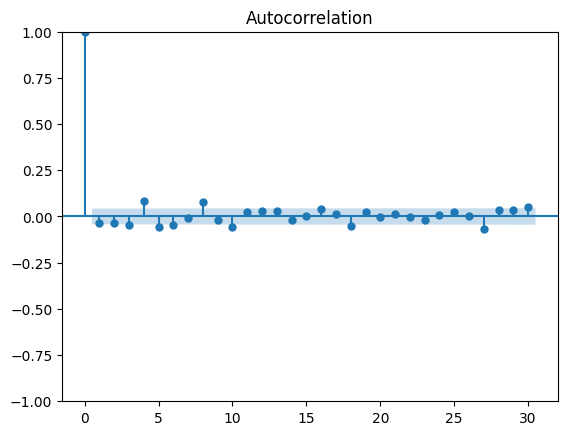

In [ ]:
# Autocorrelogram of the log-returns
from statsmodels.graphics.tsaplots import plot_acf

_ = plot_acf(log_returns, lags=30) # linear autocorrelations.

####  Non linear dependencies (heterocedasticity: time-dependent structure of the volatility;  volatility clustering)

Even though linear dependencies (correlations) are typically not present in the time series of log-returns, one does observe that there are periods in which the volatility is larger than in others (volatility clustering). This signals the presence of significant non-linear dependencies.

This heterocedasticity (time dependent structure of the variance) is apparent from the autocorrelogram of the absolute values or of the squares of the log-returns.

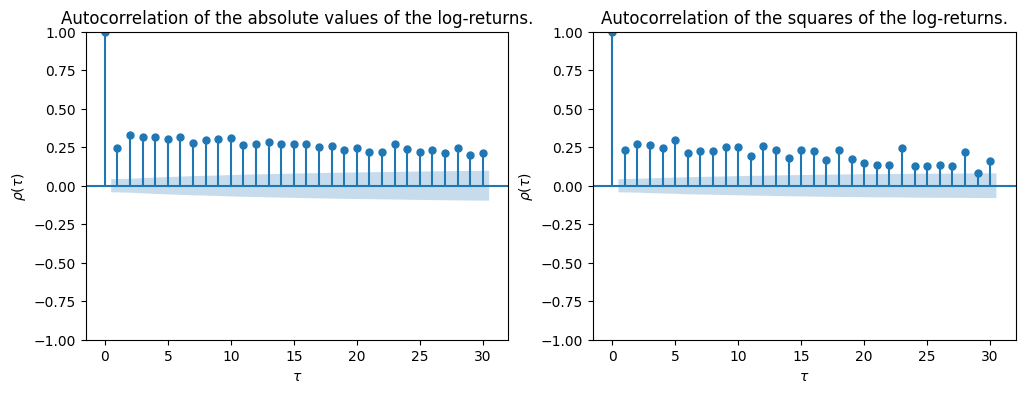

In [ ]:
# Autocorrelogram of the absolute values and of the squares of the log-returns

fig, axs = plt.subplots(1, 2, figsize=(12, 4))


_ = plot_acf(np.abs(log_returns), lags=30, ax=axs[0])
_ = axs[0].set_title('Autocorrelation of the absolute values of the log-returns.')
_ = axs[0].set_xlabel(r'$\tau$')
_ = axs[0].set_ylabel(r'$\rho(\tau)$')

_ = plot_acf(log_returns**2, lags=30, ax=axs[1]) # linear autocorrelations
_ = axs[1].set_title('Autocorrelation of the squares of the log-returns.')
_ = axs[1].set_xlabel(r'$\tau$')
_ = axs[1].set_ylabel(r'$\rho(\tau)$')



In [ ]:
p = len(phi)
r = len(alpha)
s = len(beta)

parameters_seed = np.zeros((1 + p) + (1 + r + s))
parameters_seed[0] = phi_0
parameters_seed[1:p+1] = phi
parameters_seed[p+1] = kappa
parameters_seed[p+2:p+r+2] = alpha
parameters_seed[p+r+2:] = beta

print(phi_0, phi, kappa, alpha, beta)
print(parameters_seed)

0.3 [0.1, 0.3] 0.1 [0.27] [0.7]
[0.3  0.1  0.3  0.1  0.27 0.7 ]


0.2571 [0.0957 0.292 ] 1.5067
sigma = 1.5177


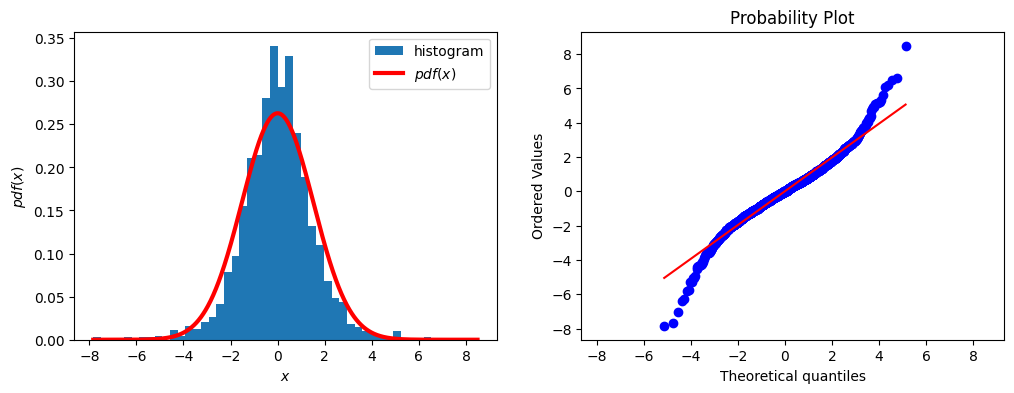

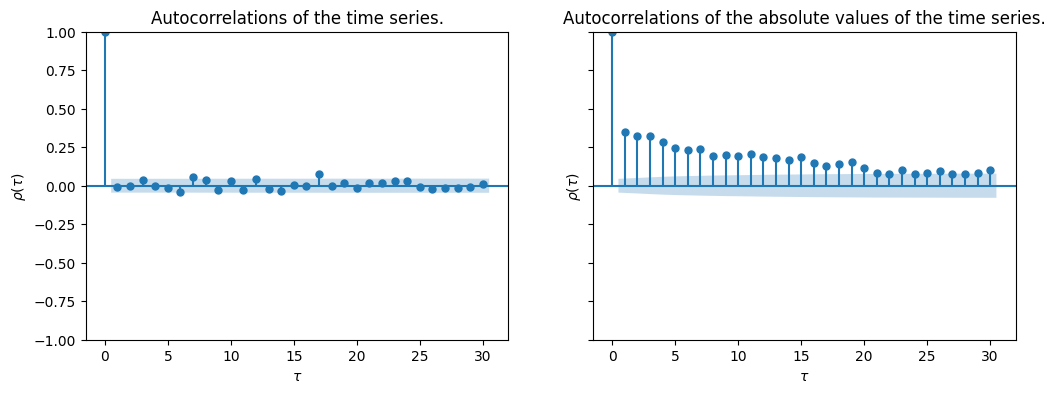

In [ ]:
print(np.round(phi_0_ML, 4), np.round(phi_ML, 4), np.round(sigma_ML, 4))

u = residuals_AR(X, phi_0_ML, phi_ML)
print('sigma = {:.4f}'.format(np.std(u)))
tests_gaussian_white_noise(u)

### Analysis of IBEX 35

In [ ]:
# Fit to AR(p) process
p = 2
phi_0_LS, phi_LS, info_optimization = fit_AR_LS(
    log_returns, phi_0_seed=0.0,  phi_seed=np.zeros(p)
)

print(np.round(phi_0_LS, 4), np.round(phi_LS, 4))

print()
print(info_optimization)

-0.0019 [-0.038  -0.0362]

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.257e+00]
           x: [-1.860e-03 -3.799e-02 -3.624e-02]
        cost: 2.546845628901676
         jac: [[ 3.344e-05  1.174e-05  1.025e-05]]
        grad: [ 7.547e-05  2.650e-05  2.314e-05]
  optimality: 7.54673802264244e-05
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 15
        njev: 8


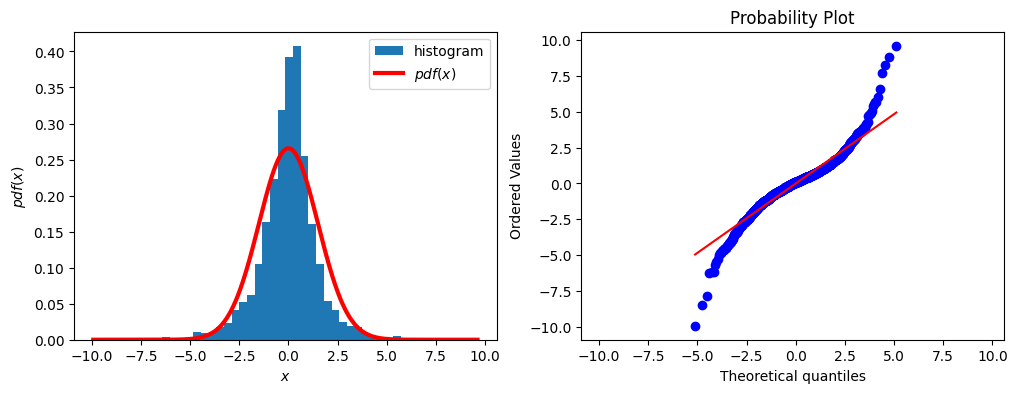

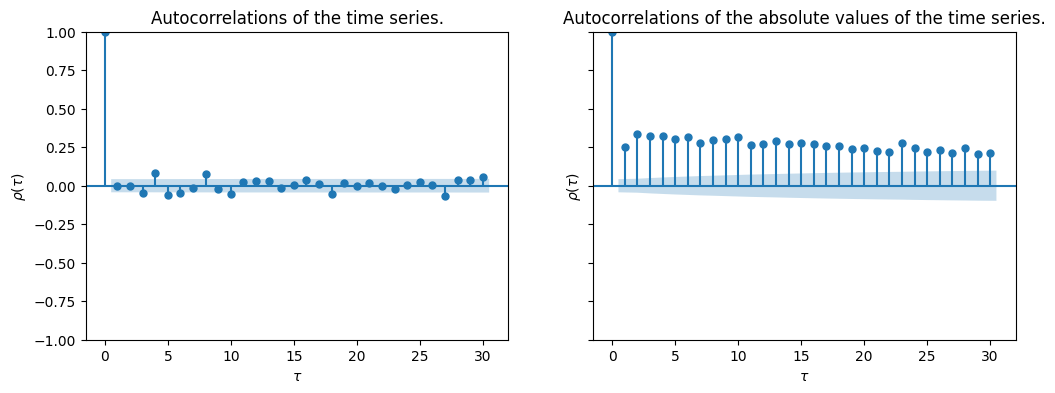

In [ ]:
# If the AR(p) model is correct, the residuals should be Gaussian white noise.
u = residuals_AR(log_returns, phi_0_LS, phi_LS)

# In this case, the residuals are still heavy-tailed and exhibit heteroskedasticity.

tests_gaussian_white_noise(u)

### Exercise 3.1: Models of financial time series

Historical series of asset returns exhibit common features, some of which are described in

Cont, Rama (2001) Empirical Properties of Asset Returns: Stylized Facts and Statistical Issues. Quantitative Finance, 1, 223-236. https://doi.org/10.1080/713665670

Among them, the following can be highlighted:

1. Returns are not independent. Specifically, the series is heteroscedastic: although the returns are not autocorrelated, the absolute values of the returns do exhibit autocorrelations. These autocorrelations are positive and persist over timescales of months, even years. This effect is known as volatility clustering.
2. The distribution of returns has heavy tails.
3. The distribution of returns is asymmetric.

To model the heavy tails, an AR(p) model with Student's t innovations can be used. However, this model cannot explain the volatility clustering phenomenon.

A GARCH(p, q) model for volatility can explain the heteroscedasticity of the series and, at least partially, the heavy tails.



1. The goal of this assignement is to fit different models to the series of log-returns of the IBEX 35.
    1. Gaussian innovations.
    2. Student's t innovations.
    3. AR(1) + Gaussian noise.
    4. AR(1) + Student's t noise.
    5. AR(1) + GARCH(1, 1) + Gaussian noise.
    6. AR(1) + GARCH(1, 1) + Student's t noise.

2. Numerically, maximizing the likelihood to fit the model to the data is a challenging problem: it involves optimization in a high-dimensional parameter space, with constraints (the model parameters must be such that the process is stationary). Numerical optimization algorithms are iterative procedures that start from a user-provided seed. The value of the seed value must be chosen carefully to ensure that the algorithm converges to the global minimum rather than diverging or converging to a suboptimal local minimum.  To ensure a good fit of the model, it may be necessary to:
    1. Run the algorithm with different initial seeds. The choice of initial seed can be guided by the statistical properties of the series (e.g., using parameters that are compatible the sample unconditional moments estimated from the sample) or by using parameter values from fits of simpler models (e.g. the $phi_1$ parameter in a fit to an AR(1) model can be used as an initial value for an AR(1) + GARCH(1, 1) model.  
    2. Implement constraints if necessary.
    3. Explore different optimization methods.

Useful information can be found in the reference page for the optimization utilities provided by scipy is https://docs.scipy.org/doc/scipy/reference/optimize.html

3. Make sure to determine in the different models whether the series of residuals $\left\{u_t \right\}$, and  $\left\{\epsilon_t = \frac{u_t}{\sqrt{h_t}}\right\}$,  have the properties that are expected: the type of distribution they have, whether or not thet are uncorrelated, independent, etcetera. Among the tests to be performed, at least the following should be done:
   1. Autocorrelation diagram for the series $\{\epsilon_t\}_{t \geq 1}$.
   2. Autocorrelation diagram for the absolute values $\{|\epsilon_t|\}_{t \geq 1}$.
   3. QQ-plot to compare the empirical percentiles of $\{\epsilon_t\}_{t \geq 1}$ with those of the model distribution.

3. Comment the results obtained from a financial viewpoint. To this end, consult the references given below. In parti cular, it is important to answer the following questions:

     1. What do the parameters in the different fitted models mean? Specifically, relate their values to the empirical properties of the time series of returns.
     3. What are the values of the degrees of freedom parameter in the fitted models in which the noise is distributed as a Student's t? Provide an interpretation of the differences, if there are any.
     2. Do these models capture the asymmetry of the return distribution? Illustrate your answer if it is positive. If not, propose a model that captures this asymmetry.

<u> References:</u>
1. Cont, Rama (2001) Empirical Properties of Asset Returns: Stylized Facts and Statistical Issues. Quantitative Finance, 1, 223-236.https://doi.org/10.1080/713665670
2. https://towardsdatascience.com/introduction-to-quantitative-finance-part-i-stylised-facts-of-asset-returns-5190581e40ea


**Apartados 1 y 3**

A la hora de ajustar cada modelo, si este es correcto, se espera que las innovaciones cumplan las siguientes propiedades:

- Media cero
- Varianza constante (homocedasticidad). Autocorrelación de los valores absolutos de la serie de residuos esta relacionado con heterocedasticidad en la serie.
- No autocorrelación lineal o no lineal
- Distribución adecuada (aquella a la que se desee ajustar)<br><br>

1. Modelo con innovaciones Gaussianas: $R_t = U_t$ donde $U_t  \sim N(\mu,\sigma)$

In [ ]:
mu_0, sigma_0 = 0.0, 1.0

(mu_1, sigma_1), info_optimization = fit_pdf_ML(
    log_returns, norm.pdf , (mu_0, sigma_0))

print('Estimaciones MV: mu = {:.4e}    sigma = {:.4f}'.format(
    mu_1, sigma_1))

print('\nCaracterísticas de los rendimientos:')
print(
    (
        'Media = {:.6f}\n'
        + 'Desviación típica (volatilidad) = {:.4f} \n'
        + 'Asimetría = {:.4f} \n'
        + 'Curtosis = {:.4f} \n'
    ).format(
        np.mean(log_returns),
        np.std(log_returns),
        skew(log_returns), # 0.0 for distributions that are symetric about the mean.
        kurtosis(log_returns),  # 3.0 for Gaussian.
    )
)

Estimaciones MV: mu = 7.7329e-04    sigma = 1.5067

Características de los rendimientos:
Media = 0.000773
Desviación típica (volatilidad) = 1.5067 
Asimetría = -0.0129 
Curtosis = 5.2803 



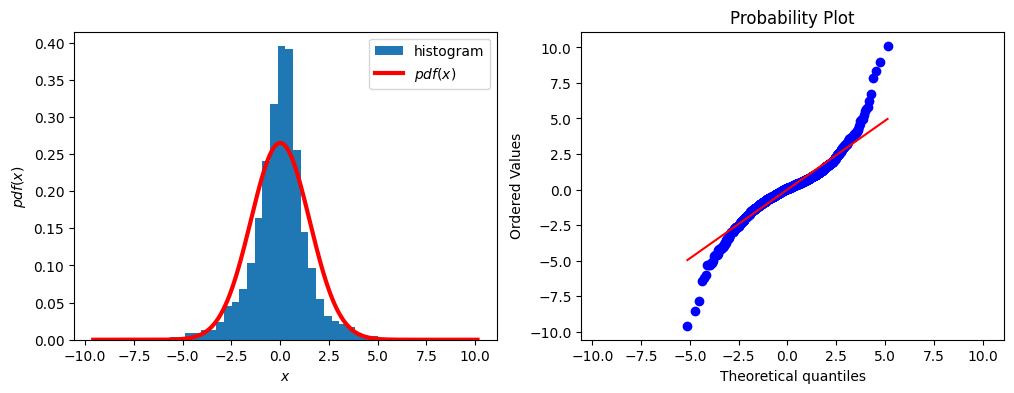

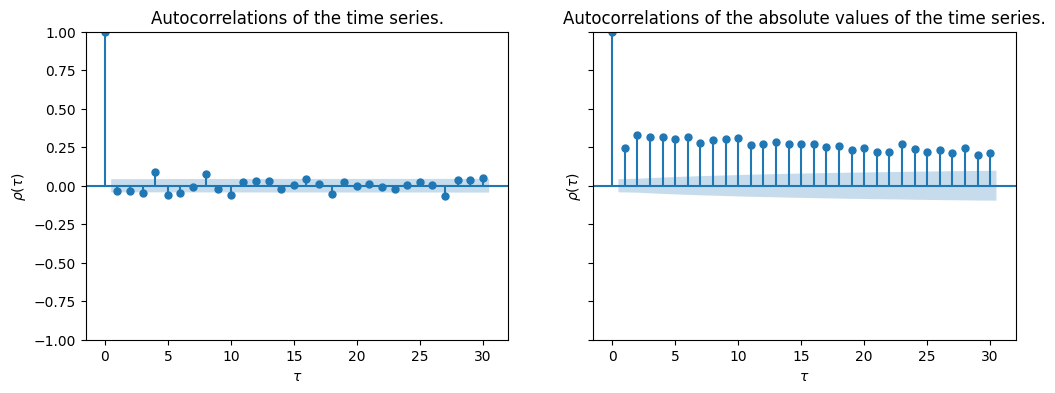

In [ ]:
tests_gaussian_white_noise(log_returns)

La estimación de máxima verosimilitud de los parámetros de una distribución normal para los rendimientos del IBEX35 son la media y desviación típica muestral, por ello podemos observar que coinciden. Segun este ajuste, los rendimientos siguen una $N(0.000773, 1.5067)$.

Sin embargo, ajustar los rendimientos del IBEX 35 a un modelo con innovaciones Gaussianas resulta inadecuado por varias razones:

- La serie presenta asimetría negativa (una cola izquierda mas pesada) y es leptocurtica (una mayor densidad en torno a la media y colas mas pesadas que la normal). Por ello, los cuantiles empíricos y teóricos difieren, especialemente en los valores extremos.
- Aunque las autocorrelaciones de la serie son muy pequeñas (la matoria estan dentro de las bandas de error), las autocorrelaciones de los valores absolutos si son significativas y persistentes en el tiempo, lo que esta relacionado con la heterocedasticidad de la serie, es decir, la volatilidad no es constante, si no que presenta una autocorrelación.

Por tanto, los residuos no siguen todas las propiedades esperadas.

2. Modelo con innovaciones t de Student: $R_t = U_t$ donde $U_t ∼ t(\nu, \mu, \sigma)$

In [ ]:
nu_seed, location_seed, scale_seed  = 10.0, 0.0, 1.0

(nu_2, location_2, scale_2), info_optimization = fit_pdf_ML(
    log_returns, stats.t.pdf, (nu_seed, location_seed, scale_seed)
)

print('Estimaciones MV: location = {:.4e}, scale = {:.4f}, nu = {:.4f}'.format(
    location_2, scale_2, nu_2))

Estimaciones MV: location = 4.2503e-02, scale = 0.9448, nu = 2.9083


<ipython-input-42-3d16de3a9ba7>:13: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, log_returns, ax=axs[1])


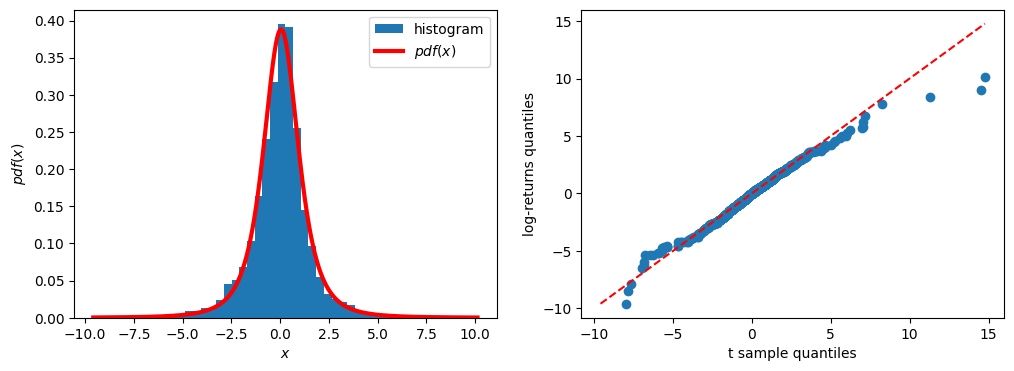

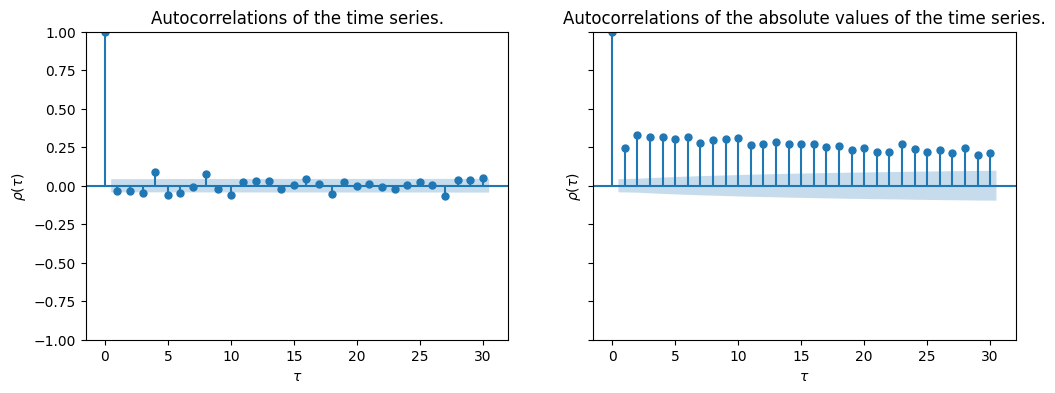

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_histogram_pdf(
    log_returns,
    lambda x: stats.t.pdf(x, nu_2, location_2, scale_2),
    n_bins=50,
    ax=axs[0],)

rng = default_rng(seed=2)
reference_sample = (
    location_2
    + scale_2 * stats.t.rvs(nu_2, size=(len(log_returns)), random_state=rng))

qqplot(reference_sample, log_returns, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
_ = plot_acf(log_returns, lags=30, ax=axs[0]) # linear autocorrelations
_ = plot_acf(np.abs(log_returns), lags=30, ax=axs[1]) # non-linear dependencies
_ = axs[0].set_title('Autocorrelations of the time series.')
_ = axs[0].set_xlabel(r'$\tau$')
_ = axs[0].set_ylabel(r'$\rho(\tau)$')

_ = axs[1].set_title('Autocorrelations of the absolute values of the time series.')
_ = axs[1].set_xlabel(r'$\tau$')
_ = axs[1].set_ylabel(r'$\rho(\tau)$')



La distribución t de Student permite mayor flexibilidad a la hora de ajustar la densidad de las colas y el apuntamiento de la distribución, uno de los problemas de la distribución normal, mostrado anteriormente. Podemos observar como el histograma de los rendimientos se ajusta relativamente bien a una t de Student con los parámetros estimados por máxima verosimilutud, a una $t(\mu=0.042503, \sigma=0.9448, \nu=2.9083)$.

A pesar de ello, los cuantiles empíricos tambien presentan un desajuste con los cuantiles teóricos para los valores extremos. La distribucion $t$ de Student predice unos cuantiles mayores en ambos lados, es decir, asumiendo que los rendimientos siguen esta distribución, se espera que los rendimientos mas altos sean superiores a los mas altos observados y que los rendimientos mas bajos sean mayores a los observados. Existe, por tanto, una sobreestimación de los rendimientos en los extremos de las colas.

Al igual que con la distribución normal, (la serie de residuos es la misma, los propios rendimientos) los rendimientos estan centrados en cero pero la serie presenta una autocorrelación en valor absoluto, indicio de que la varianza no sería constante.

Por tanto, el ajuste de los rendimientos a la distribución $t$ de Student tampoco es el mas correcto.

3. Modelo AR(1) con ruido Gaussiano: $R_t = \phi_0 + \phi_1 R_{t-1} + U_t$ donde $U_t \sim N(\mu, \sigma)$

Estimaciones de MV:
phi_0: 0.0002, phi_1: [-0.0355]

¿Media cero de los residuos? -> 1.9096551027725755e-06


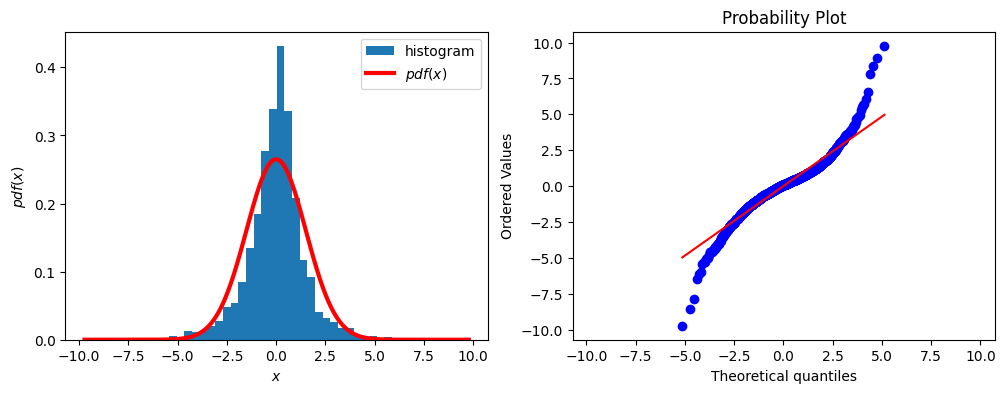

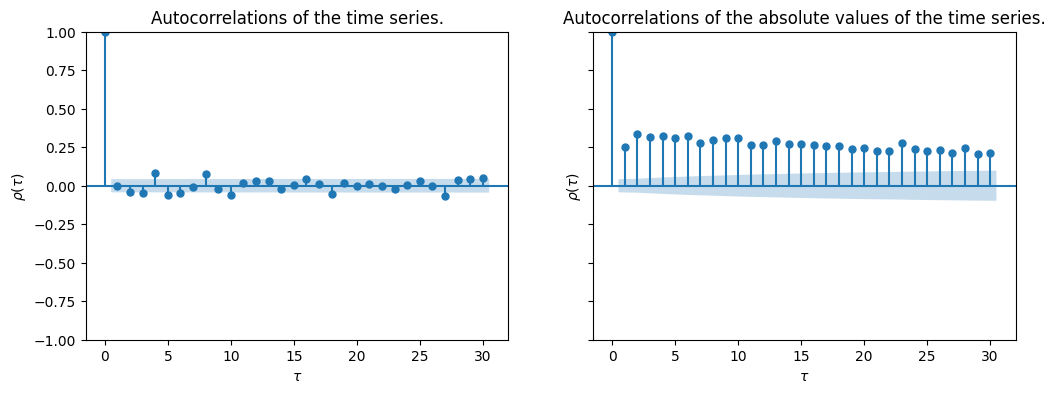

In [ ]:
p = 1
phi_0_3, phi_1_3, info_optimization = fit_AR_LS(
    log_returns, phi_0_seed=0.0,  phi_seed=np.zeros(p)
)

print("Estimaciones de MV:")
print(f'phi_0: {np.round(phi_0_3, 4)}, phi_1: {np.round(phi_1_3, 4)}')

u_3 = residuals_AR(log_returns, phi_0_3, phi_1_3)

tests_gaussian_white_noise(u_3)

print(f'\n¿Media cero de los residuos? -> {np.mean(u_3)}')

Según la estimación por máxima verosimulitud, los rendimientos siguen un proceso autorregresivo $R_t = 0.002 - 0.0355R_{t-1} + U_t$, es decir los rendimientos entre periodos estarían ligeramente correlacionados negativamente. Veamos si el ajuste es bueno y las innovaciones cumplen las propiedades de ruido blanco Gaussiano:

- Tienen media cero aproximadamente
- Presentan autocorrelación dentro de las bandas de error con la mayoria de retardos, se podría concluir que las innovaciones estan incorrelacionadas linealmente.
- La autocorrelación de los valores absolutos es significativa, por lo que se trata de una seria no estacionaria en varianza. No cumple el supuesto de homocedasticidad del ruido blanco.
- Tal y como se observa en el grafico de los cuantiles empiricos y observados y en el histograma junto con la pdf teorica, el ajuste a una distribución normal no es bueno, especialmente en torno a la media y en las colas.



4. Modelo AR(1) con ruido t de Student: $R_t = \phi_0 + \phi_1 R_{t-1} + U_t$ donde $U_t \sim t(\nu, \mu, \sigma)$

In [ ]:
p = 1
phi_0_4, phi_1_4, scale_4, nu_4, info_optimization = fit_AR_ML_student_t_noise(log_returns, phi_0_seed=0.0, phi_seed=np.zeros(p), sigma_seed=10, nu_seed=0.0 )


print("Estimaciones de MV:")
print("phi_0   phi_1   scale  nu")
print(np.round(phi_0_4, 4), np.round(phi_1_4, 4), np.round(scale_4, 4), np.round(nu_4, 4))

Estimaciones de MV:
phi_0   phi_1   scale  nu
0.044 [-0.017] 0.9437 2.9027


/content/my_time_series_MIGUEL.py:356: RuntimeWarning: divide by zero encountered in log
  nu = np.exp(np.log(parameters[-1]))
/content/my_time_series_MIGUEL.py:362: RuntimeWarning: divide by zero encountered in log
  - 0.5 * np.log(nu * np.pi)
/content/my_time_series_MIGUEL.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  gammaln((nu + 1) / 2)
/content/my_time_series_MIGUEL.py:364: RuntimeWarning: divide by zero encountered in divide
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * sigma**2)) )
/content/my_time_series_MIGUEL.py:364: RuntimeWarning: invalid value encountered in divide
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * sigma**2)) )
/content/my_time_series_MIGUEL.py:357: RuntimeWarning: invalid value encountered in log
  sigma = np.exp(np.log(parameters[-2]))



¿Media cero de los residuos? -> -0.04380655228291817


<ipython-input-45-b9f27de0321e>:16: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, u_4, ax=axs[1])


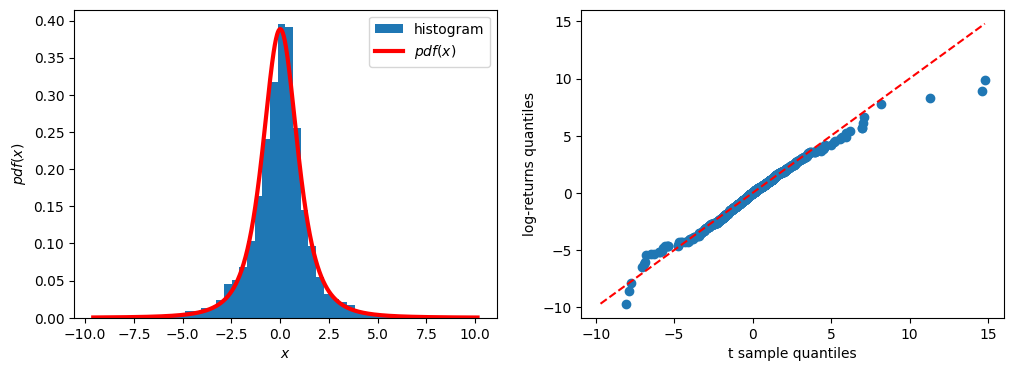

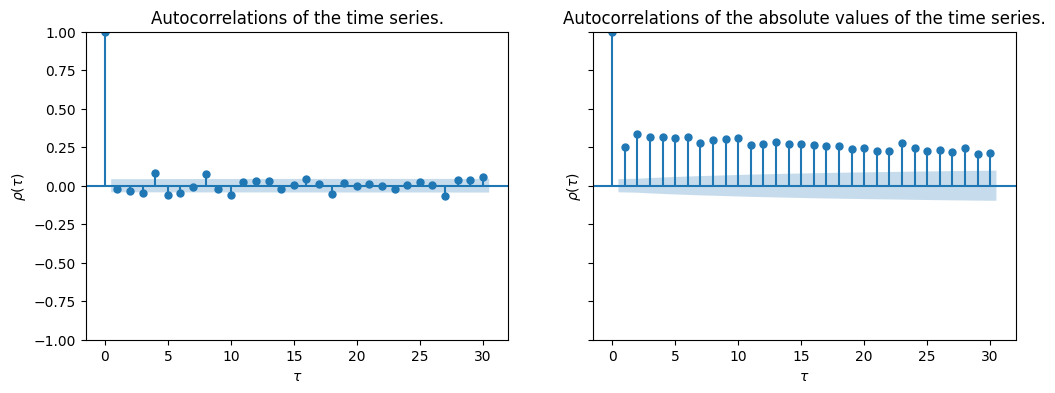

In [ ]:
u_4 = residuals_AR(log_returns, phi_0_4, phi_1_4)

print(f'\n¿Media cero de los residuos? -> {np.mean(u_4)}')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_histogram_pdf(
    log_returns,
    lambda x: stats.t.pdf(x, nu_4, 0.0, scale_4),
    n_bins=50,
    ax=axs[0],)

rng = default_rng(seed=2)
reference_sample = (
    0.0 + scale_4 * stats.t.rvs(nu_4, size=(len(log_returns)), random_state=rng))

qqplot(reference_sample, u_4, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
_ = plot_acf(u_4, lags=30, ax=axs[0]) # linear autocorrelations
_ = plot_acf(np.abs(u_4), lags=30, ax=axs[1]) # non-linear dependencies
_ = axs[0].set_title('Autocorrelations of the time series.')
_ = axs[0].set_xlabel(r'$\tau$')
_ = axs[0].set_ylabel(r'$\rho(\tau)$')

_ = axs[1].set_title('Autocorrelations of the absolute values of the time series.')
_ = axs[1].set_xlabel(r'$\tau$')
_ = axs[1].set_ylabel(r'$\rho(\tau)$')

En este caso, la estimación por máxima verosimulitud sugiere que los rendimientos siguen un AR(1) de la siguiente forma: $R_t = 0.044 - 0.017R_{t-1} + U_t$ donde $U_t \sim t(\mu=0, \sigma=0.9437, \nu=2.9027)$
- La media de los residuos difiere de 0.
- El ajuste a la $t$ de Student difiere en las colas de los cuantiles teoricos.
- Las innovaciones presentan autocorrelación significativa con algunos de sus retardos. Además, hay autocorrelación no lineal con todos los retardos (al menos hasta $\tau = 30$), con lo que la serie presenta varianza cambiante en el tiempo.
Por tanto, las innovaciones del modelo no cumplen ninguna de las propiedades que deberian cumplir si este fuese correcto.

5. Modelo AR(1) + GARCH(1, 1) + Ruido blanco Gaussiano: <br> $R_t = \phi_0 + \phi_1 R_{t-1} + U_t$ <br> $U_t = \epsilon_t\sqrt{h_t}; \epsilon_t \overset{\text{iid}} \sim N$ <br>  $h_t = \kappa + \alpha U_{t-1}^2 + \beta h_{t-1}$

In [ ]:
phi_0_seed, phi_seed, kappa_seed, alpha_seed, beta_seed = 0.0, [0.0], 0.0, [0.0], [0.0]

phi_0_5, phi_1_5, kappa_5, alpha_5, beta_5, _ = fit_AR_GARCH_ML_gaussian_noise(
    log_returns,
    phi_0_seed,
    phi_seed,
    kappa_seed,
    alpha_seed,
    beta_seed)

print("Resultados de la estimacion de MV:")
print(f'phi_0: {np.round(phi_0_5, 5)}, phi_1: {np.round(phi_1_5, 5)}, kappa: {np.round(kappa_5, 5)}, alpha: {np.round(alpha_5, 5)}, beta: {np.round(beta_5, 5)}')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2087: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/content/my_time_series_MIGUEL.py:414: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))


Resultados de la estimacion de MV:
phi_0: 0.04463, phi_1: [-0.01876], kappa: 0.01975, alpha: [0.09075], beta: [0.90213]


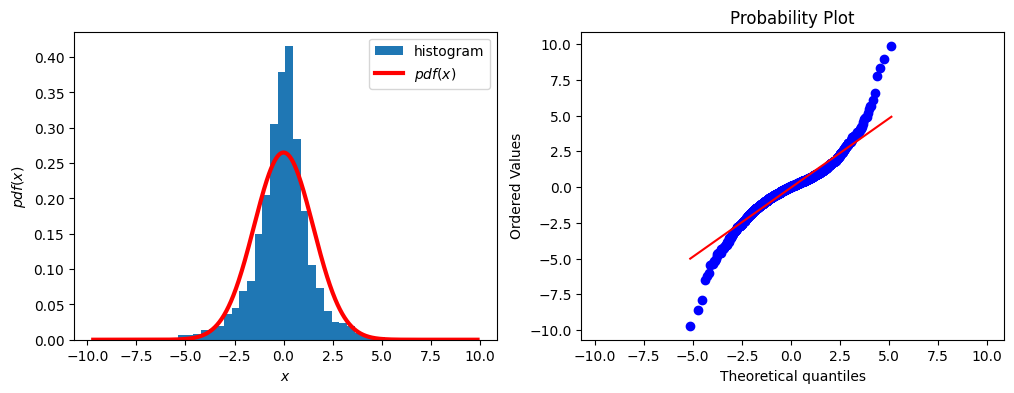

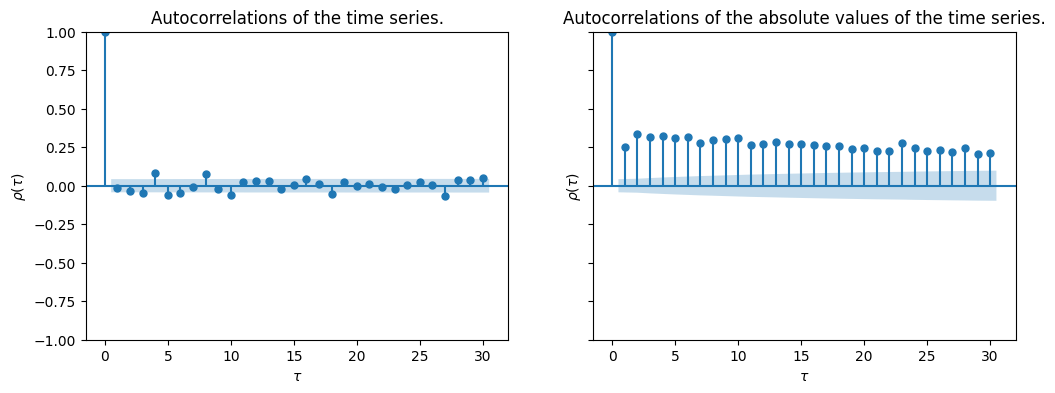

In [ ]:
u_5, h_5 = residuals_ARMA_GARCH(
    log_returns,
    phi_0=phi_0_5,
    phi=phi_1_5,
    theta=[],
    kappa=kappa_5,
    alpha=alpha_5,
    beta=beta_5
)

tests_gaussian_white_noise(u_5)

Los residuos $U_t$, al igual que en los casos anteriores, no cumplen las propiedades de ruido blanco. En este caso, son las innovaciones $\epsilon_t$ las que deben ser normales e $iid$.


¿Media cero de las innovaciones? -> 0.006240868066679155


np.float64(1.0169941122882484)

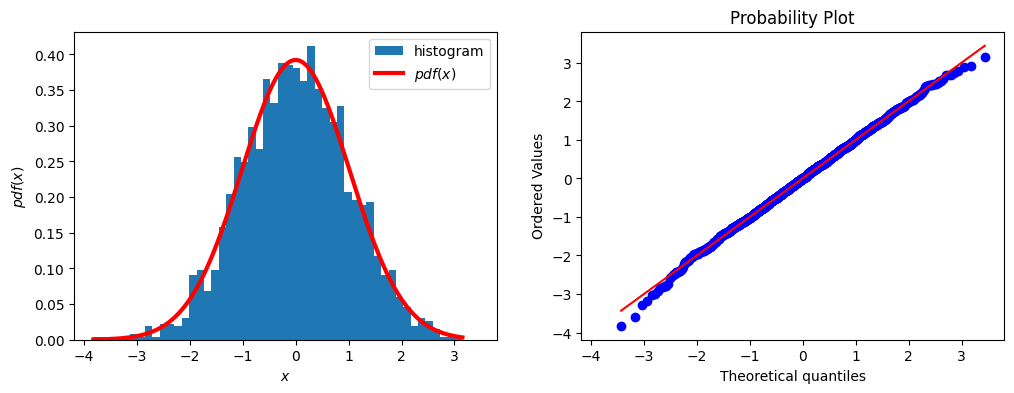

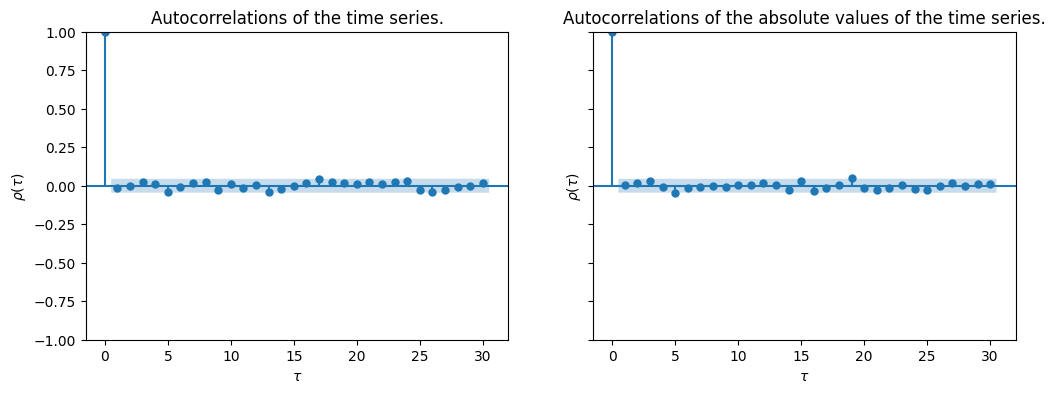

In [ ]:
epsilon_5 = u_5 / np.sqrt(h_5)
tests_gaussian_white_noise(epsilon)

print(f'\n¿Media cero de las innovaciones? -> {np.mean(epsilon)}')
np.std(epsilon)

- La media de $\epsilon_t$ es distinta de cero
- La serie no presenta ningun tipo de autocorrelación, lineal y no lineal, por lo que no se detecta heterocedasticidad.
- El ajuste a la distribución normal es relativamente bueno, excepto en los valores de las colas. Tal y como es de esperar, la normal no recoge los eventos extremos en los rendimientos adecuadamente.

Por tanto, pese a que el ajuste no es el ideal, la introducción del GARCH(1,1), que introduce volatilidad cambiante en el tiempo para las innovaciones $U_t$, permite la no autocorrelación no lineal y, por tanto, la heterocedasticidad de las innovaciones $\epsilon_t$.

6.	Modelo AR(1) + GARCH(1, 1) + ruido $t$ de Student: <br> $R_t = \phi_0 + \phi_1 R_{t-1} + U_t$ <br> $U_t = \epsilon_t\sqrt{h_t}; \epsilon_t \overset{\text{iid}} \sim  t$ <br>  $h_t = \kappa + \alpha U_{t-1}^2 + \beta h_{t-1}$

In [ ]:
phi_0_seed, phi_seed, kappa_seed, alpha_seed, beta_seed, nu_seed = 0.0, [0.0], 0.0, [0.0], [0.0], 10

phi_0_6, phi_1_6, kappa_6, alpha_6, beta_6, nu_6, _ =  fit_AR_GARCH_ML_student_t_noise(
    log_returns,
    phi_0_seed,
    phi_seed,
    kappa_seed,
    alpha_seed,
    beta_seed,
    nu_seed)

print("Resultados de la estimacion de MV:")
print(f'phi_0: {np.round(phi_0_6, 5)}, phi_1: {np.round(phi_1_6, 5)}, kappa: {np.round(kappa_6, 5)}, alpha: {np.round(alpha_6, 5)}, beta: {np.round(beta_6, 5)}, nu: {np.round(nu_6, 5)}')


/content/my_time_series_MIGUEL.py:476: RuntimeWarning: divide by zero encountered in log
  - gammaln(nu / 2) - 0.5 * np.log(h)
/content/my_time_series_MIGUEL.py:477: RuntimeWarning: divide by zero encountered in divide
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:477: RuntimeWarning: invalid value encountered in divide
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:474: RuntimeWarning: invalid value encountered in subtract
  log_likelihood = ( gammaln((nu + 1) / 2)
/content/my_time_series_MIGUEL.py:475: RuntimeWarning: invalid value encountered in log
  - 0.5 * np.log(np.pi * nu)
/content/my_time_series_MIGUEL.py:477: RuntimeWarning: invalid value encountered in log
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:476: RuntimeWarning: invalid value encountered in log
  - gammaln(nu / 2) - 0.5 * np.log(h)


Resultados de la estimacion de MV:
phi_0: -0.15609, phi_1: [0.38218], kappa: 0.04389, alpha: [0.0602], beta: [-0.00914], nu: 0.80855



¿Media cero de los residuos? -> 0.006240868066679155


<ipython-input-50-7ac5e5a7e922>:25: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, epsilon_6, ax=axs[1])


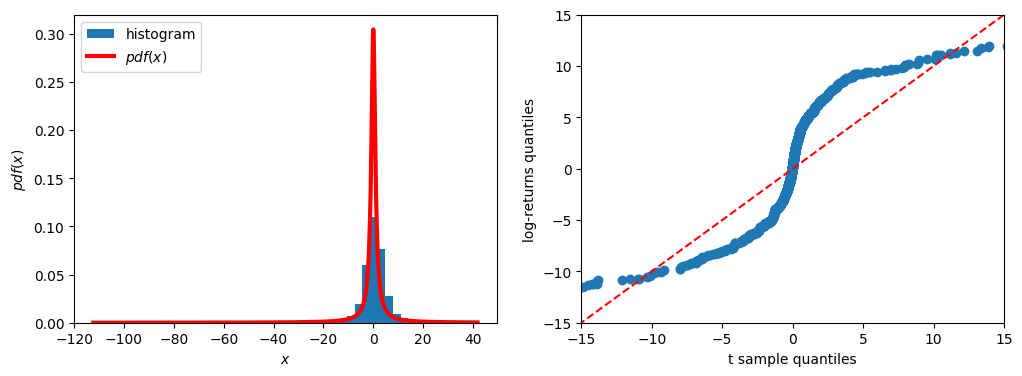

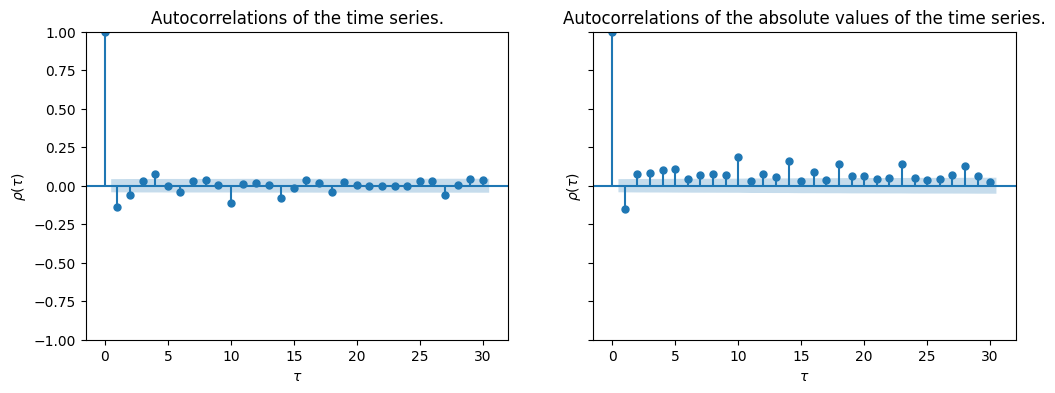

In [ ]:
u_6, h_6 = residuals_ARMA_GARCH(
    log_returns,
    phi_0=phi_0_6,
    phi=phi_1_6,
    theta=[],
    kappa=kappa_6,
    alpha=alpha_6,
    beta=beta_6
)
epsilon_6 = u_6 / np.sqrt(h_6)

print(f'\n¿Media cero de los residuos? -> {np.mean(epsilon)}')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_histogram_pdf(
    epsilon_6,
    lambda x: stats.t.pdf(x, nu_6, 0.0, 1.0),
    n_bins=50,
    ax=axs[0],)

rng = default_rng(seed=2)
reference_sample = (stats.t.rvs(nu_6, size=(len(epsilon_6)), random_state=rng) * np.sqrt(h_6))

qqplot(reference_sample, epsilon_6, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')
_ = axs[1].set_xlim(-15, 15)
_ = axs[1].set_ylim(-15, 15)


fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
_ = plot_acf(epsilon_6, lags=30, ax=axs[0]) # linear autocorrelations
_ = plot_acf(np.abs(epsilon_6), lags=30, ax=axs[1]) # non-linear dependencies
_ = axs[0].set_title('Autocorrelations of the time series.')
_ = axs[0].set_xlabel(r'$\tau$')
_ = axs[0].set_ylabel(r'$\rho(\tau)$')

_ = axs[1].set_title('Autocorrelations of the absolute values of the time series.')
_ = axs[1].set_xlabel(r'$\tau$')
_ = axs[1].set_ylabel(r'$\rho(\tau)$')

En este ultimo modelo, las innovaciones no cumplen ninguna de las propiedades que deberían:
- La media es distinta de cero
- Los valores absolutos de la serie presentan autocorrelación, con lo que la varianza  de las innovaciones no es constante en el tiempo
- Hay autocorrelación para varios retardos
- El ajuste a la t de Student no es óptimo: los cuantiles teóricos y empíricos son diferentes.

Viendo la ayuda de la funcion minimize nos damos cuenta de que el metodo utilizado es el simplex, que solo funciona para funciones lineales. Por ello debemos utilizar distintos metodos de optimización y estableces restricciones a los parametros como $\nu > 2$, lo cual no se cumple en este modelo.

**Apartado 2**




En cuanto al segundo apartado, en el que se nos pide explorar distintos métodos de optimización para hallar el mínimo de la función de log-verosimilitud, cabe recalcar que el método predeterminado que utilizamos en todos los métodos es el 'nelder-mead', que es el algoritmo símplex. Para añadir restricciones u obtener un algoritmo de resolución no lineal, proponemos utilizar el método 'SLSQP', 'Sequential Least Squares Programming', tras leer la documentación de la función scipy.optimize.minimize, nos parece el más adecuado. En la función my_time_series, hemos implementado el algoritmo de optimización con este método y con las restricciones pertinentes para cada modelo.

In [ ]:
# First model

mu_seeds    = [-1.0, 0.0, 1.0]
sigma_seeds = [ 1.0, 2.0, 3.0]
results = []

for mu0 in mu_seeds:
    for sigma0 in sigma_seeds:
        (mu_est, sigma_est), info_optimization = fit_pdf_ML(
            log_returns,
            norm.pdf,
            (mu0, sigma0)
        )

        results.append({
            'mu_seed':    mu0,
            'sigma_seed': sigma0,
            'mu_est':     mu_est,
            'sigma_est':  sigma_est,
            'fun_value':  info_optimization.fun
        })

df = pd.DataFrame(results,
                  columns=['mu_seed', 'sigma_seed', 'mu_est', 'sigma_est', 'fun_value'])
print(df.to_string(index=False))


 mu_seed  sigma_seed   mu_est  sigma_est  fun_value
    -1.0         1.0 0.000773   1.506685    1.82885
    -1.0         2.0 0.000773   1.506685    1.82885
    -1.0         3.0 0.000773   1.506685    1.82885
     0.0         1.0 0.000773   1.506685    1.82885
     0.0         2.0 0.000773   1.506685    1.82885
     0.0         3.0 0.000773   1.506685    1.82885
     1.0         1.0 0.000773   1.506685    1.82885
     1.0         2.0 0.000773   1.506685    1.82885
     1.0         3.0 0.000773   1.506685    1.82885


Para el primer modelo, al ser muy sencillo, el optimizador siempre llega al mismo resultado. No necesitaríamos añadir restricciones para el modelo de perturbaciones normales homocedásticas, como mucho $\sigma > 0$, pero no sería necesario.

In [ ]:
# First model

mu_seeds    = [-1.0, 0.0, 1.0]
sigma_seeds = [ 1.0, 2.0, 3.0]
results = []

for mu0 in mu_seeds:
    for sigma0 in sigma_seeds:
        (mu_est, sigma_est), info_optimization = fit_pdf_ML_SLSQP(
            log_returns,
            norm.pdf,
            (mu0, sigma0)
        )

        results.append({
            'mu_seed':    mu0,
            'sigma_seed': sigma0,
            'mu_est':     mu_est,
            'sigma_est':  sigma_est,
            'fun_value':  info_optimization.fun
        })

df = pd.DataFrame(results,
                  columns=['mu_seed', 'sigma_seed', 'mu_est', 'sigma_est', 'fun_value'])
print(df.to_string(index=False))

 mu_seed  sigma_seed   mu_est  sigma_est  fun_value
    -1.0         1.0 0.001456   1.506643    1.82885
    -1.0         2.0 0.001436   1.506711    1.82885
    -1.0         3.0 0.000746   1.506660    1.82885
     0.0         1.0 0.000791   1.507095    1.82885
     0.0         2.0 0.000708   1.507072    1.82885
     0.0         3.0 0.000651   1.506794    1.82885
     1.0         1.0 0.000088   1.506637    1.82885
     1.0         2.0 0.000112   1.506712    1.82885
     1.0         3.0 0.000802   1.506661    1.82885


/content/model_calibration.py:90: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/model_calibration.py:27: RuntimeWarning: divide by zero encountered in log
  return - np.mean(np.log(model(X, *parameters)))


Utilizando ambos optimizadores, símplex y 'SLSQP' el resultado es similar.


In [ ]:
# Second model

from itertools import product

nu_seeds = [3, 6, 10]
location_seeds = [0, 1, 2]
scale_seeds = [1, 3, 5]

print(f"{'nu_seed':>8} {'loc_seed':>9} {'scale_seed':>12}  ||  {'nu_hat':>8} {'loc_hat':>9} {'scale_hat':>12}")
print("-" * 60)

for nu_0, loc_0, scale_0 in product(nu_seeds, location_seeds, scale_seeds):
    (nu_hat, loc_hat, scale_hat), _ = fit_pdf_ML(
        log_returns,
        stats.t.pdf,
        (nu_0, loc_0, scale_0)
    )

    print(f"{nu_0:8.1f} {loc_0:9.1f} {scale_0:12.1f}  ||  {nu_hat:8.3f} {loc_hat:9.3f} {scale_hat:12.3f}")


 nu_seed  loc_seed   scale_seed  ||    nu_hat   loc_hat    scale_hat
------------------------------------------------------------
     3.0       0.0          1.0  ||     2.908     0.043        0.945
     3.0       0.0          3.0  ||     2.908     0.043        0.945
     3.0       0.0          5.0  ||     2.908     0.043        0.945
     3.0       1.0          1.0  ||     2.908     0.043        0.945
     3.0       1.0          3.0  ||     2.908     0.043        0.945
     3.0       1.0          5.0  ||     2.908     0.043        0.945
     3.0       2.0          1.0  ||     2.908     0.043        0.945
     3.0       2.0          3.0  ||     2.908     0.043        0.945
     3.0       2.0          5.0  ||     2.908     0.043        0.945
     6.0       0.0          1.0  ||     2.908     0.043        0.945
     6.0       0.0          3.0  ||     2.908     0.043        0.945
     6.0       0.0          5.0  ||     2.908     0.043        0.945
     6.0       1.0          1.0  ||     2.

Como comprobamos, para distintas semillas obtenemos los mismos resultados. Cabe destacar que habría que introducir la restricción en este modelo de $\nu > 2$, ya que en caso contrario, la varianza del modelo sería infinita. En el ejemplo de abajo utilizamos el optimizador alternativo, incluyendo esta restricción.

In [ ]:
# Second model

nu_seeds = [3, 6, 10]
location_seeds = [0, 1, 2]
scale_seeds = [1, 3, 5]

print(f"{'nu_seed':>8} {'loc_seed':>9} {'scale_seed':>12}  ||  {'nu_hat':>8} {'loc_hat':>9} {'scale_hat':>12}")
print("-" * 60)

for nu_0, loc_0, scale_0 in product(nu_seeds, location_seeds, scale_seeds):
    (nu_hat, loc_hat, scale_hat), _ = fit_pdf_ML_SLSQP(
        log_returns,
        stats.t.pdf,
        (nu_0, loc_0, scale_0)
    )

    print(f"{nu_0:8.1f} {loc_0:9.1f} {scale_0:12.1f}  ||  {nu_hat:8.3f} {loc_hat:9.3f} {scale_hat:12.3f}")


 nu_seed  loc_seed   scale_seed  ||    nu_hat   loc_hat    scale_hat
------------------------------------------------------------
     3.0       0.0          1.0  ||     3.001     0.042        0.953
     3.0       0.0          3.0  ||     2.912     0.042        0.945


/content/model_calibration.py:83: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/model_calibration.py:90: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


     3.0       0.0          5.0  ||     2.908     0.043        0.945
     3.0       1.0          1.0  ||     2.904     0.043        0.945
     3.0       1.0          3.0  ||     2.907     0.043        0.945
     3.0       1.0          5.0  ||     2.909     0.043        0.945
     3.0       2.0          1.0  ||     2.908     0.043        0.945
     3.0       2.0          3.0  ||     2.912     0.042        0.945
     3.0       2.0          5.0  ||     2.904     0.042        0.945
     6.0       0.0          1.0  ||     2.909     0.042        0.945
     6.0       0.0          3.0  ||     2.913     0.042        0.945
     6.0       0.0          5.0  ||     2.910     0.043        0.944
     6.0       1.0          1.0  ||     2.908     0.042        0.945
     6.0       1.0          3.0  ||     2.913     0.043        0.945
     6.0       1.0          5.0  ||     2.908     0.043        0.945
     6.0       2.0          1.0  ||     2.907     0.042        0.945
     6.0       2.0          3.0  |

De nuevo, al utilizar un optimizador diferente, obtenemos resultados diferentes pero muy semejantes.

In [ ]:
# Third model

phi_0_seeds = [0, 1, 2]
phi_1_seeds = [-0.5, 0, 0.5]
sigma_seeds = [1, 2, 3]

print(f"{'phi_0_seed':>10} {'phi_1_seed':>10} {'sigma_seed':>12}  ||  {'phi_0_hat':>10} {'phi_1_hat':>10} {'sigma_hat':>12}")
print("-" * 70)

for phi_0_0, phi_1_0, sigma_0 in product(phi_0_seeds, phi_1_seeds, sigma_seeds):
    phi_0_hat, phi_hat, sigma_hat, _ = fit_AR_ML_gaussian_noise(
        log_returns,
        phi_0_seed=phi_0_0,
        phi_seed=np.array([phi_1_0]),
        sigma_seed=sigma_0,
    )

    print(f"{phi_0_0:10.1f} {phi_1_0:10.1f} {sigma_0:12.1f}  ||  {phi_0_hat:10.4f} {phi_hat[0]:10.4f} {sigma_hat:12.4f}")


phi_0_seed phi_1_seed   sigma_seed  ||   phi_0_hat  phi_1_hat    sigma_hat
----------------------------------------------------------------------
       0.0       -0.5          1.0  ||      0.0002    -0.0355       1.5058
       0.0       -0.5          2.0  ||      0.0002    -0.0355       1.5058
       0.0       -0.5          3.0  ||      0.0002    -0.0355       1.5058
       0.0        0.0          1.0  ||      0.0002    -0.0355       1.5058
       0.0        0.0          2.0  ||      0.0002    -0.0355       1.5058
       0.0        0.0          3.0  ||      0.0002    -0.0355       1.5058
       0.0        0.5          1.0  ||      0.0002    -0.0355       1.5058
       0.0        0.5          2.0  ||      0.0002    -0.0355       1.5058
       0.0        0.5          3.0  ||      0.0002    -0.0355       1.5058
       1.0       -0.5          1.0  ||      0.0002    -0.0355       1.5058
       1.0       -0.5          2.0  ||      0.0002    -0.0355       1.5058
       1.0       -0.5        

Como se puede comprobar, todas las iteraciones dan igual usando el símplex, de nuevo, al ser un método muy sencillo. Cabe destacar que estamos usando semillas "próximas" en todas las pruebas para que obtener el resultado que debería. En este caso, la restricción que deberíamos implementar para este modelo es que $|\phi_1| < 1$ para que el proceso sea estacionario. Como vemos, si utilizásemos de semilla para $\phi_1 = 10000$, por ejemplo:

In [ ]:
print(f"{'phi_0_seed':>10} {'phi_1_seed':>10} {'sigma_seed':>12}  ||  {'phi_0_hat':>10} {'phi_1_hat':>10} {'sigma_hat':>12}")
print("-" * 70)

phi_0_ML, phi_ML, sigma_ML, info_optimization  = fit_AR_ML_gaussian_noise(
    log_returns,
    phi_0_seed=0.0,
    phi_seed=[10000.0],
    sigma_seed=1.0,
)

print(f"{0.0:10.1f} {10000.0:10.1f} {1.0:12.1f}  ||  {phi_0_ML:10.4f} {phi_ML[0]:10.4f} {sigma_ML:12.4f}")


phi_0_seed phi_1_seed   sigma_seed  ||   phi_0_hat  phi_1_hat    sigma_hat
----------------------------------------------------------------------
       0.0    10000.0          1.0  ||      0.0012    -0.0355       1.5058


Se realiza una mala estimación de $\phi_0$. Utilizando el optimizador alternativo y añadiendo la restricción pertinente:

In [ ]:
# Third model

phi_0_seeds = [0, 1, 2]
phi_1_seeds = [-0.5, 0, 0.5]
sigma_seeds = [1, 2, 3]

print(f"{'phi_0_seed':>10} {'phi_1_seed':>10} {'sigma_seed':>12}  ||  {'phi_0_hat':>10} {'phi_1_hat':>10} {'sigma_hat':>12}")
print("-" * 70)

for phi_0_0, phi_1_0, sigma_0 in product(phi_0_seeds, phi_1_seeds, sigma_seeds):
    phi_0_hat, phi_hat, sigma_hat, _ = fit_AR_ML_gaussian_noise_SLSQP(
        log_returns,
        phi_0_seed=phi_0_0,
        phi_seed=np.array([phi_1_0]),
        sigma_seed=sigma_0,
    )

    print(f"{phi_0_0:10.1f} {phi_1_0:10.1f} {sigma_0:12.1f}  ||  {phi_0_hat:10.4f} {phi_hat[0]:10.4f} {sigma_hat:12.4f}")


phi_0_seed phi_1_seed   sigma_seed  ||   phi_0_hat  phi_1_hat    sigma_hat
----------------------------------------------------------------------
       0.0       -0.5          1.0  ||      0.0002    -0.0355       1.5059
       0.0       -0.5          2.0  ||      0.0002    -0.0355       1.5058
       0.0       -0.5          3.0  ||      0.0002    -0.0355       1.5066
       0.0        0.0          1.0  ||      0.0002    -0.0355       1.5062
       0.0        0.0          2.0  ||      0.0001    -0.0355       1.5062
       0.0        0.0          3.0  ||      0.0001    -0.0351       1.5058
       0.0        0.5          1.0  ||      0.0002    -0.0355       1.5059
       0.0        0.5          2.0  ||      0.0001    -0.0355       1.5058
       0.0        0.5          3.0  ||      0.0002    -0.0352       1.5057
       1.0       -0.5          1.0  ||      0.0003    -0.0356       1.5058
       1.0       -0.5          2.0  ||      0.0002    -0.0355       1.5058
       1.0       -0.5        

/content/my_time_series_MIGUEL.py:373: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(


       1.0        0.5          3.0  ||      0.0008    -0.0355       1.5049
       2.0       -0.5          1.0  ||      0.0001    -0.0355       1.5059
       2.0       -0.5          2.0  ||     -0.0008    -0.0355       1.5057
       2.0       -0.5          3.0  ||      0.0008    -0.0359       1.5063
       2.0        0.0          1.0  ||      0.0002    -0.0355       1.5060
       2.0        0.0          2.0  ||      0.0003    -0.0356       1.5058
       2.0        0.0          3.0  ||      0.0011    -0.0354       1.5055
       2.0        0.5          1.0  ||     -0.0000    -0.0355       1.5062
       2.0        0.5          2.0  ||      0.0002    -0.0354       1.5059
       2.0        0.5          3.0  ||     -0.0002    -0.0352       1.5060


De nuevo, se puede comprobar que dan los mismos resultados.

In [ ]:
# Fourth model

# Supongamos que p = 1 (AR(1))
p = 1

# Semillas
phi_0_seeds = [-10.0, 0.0, 10.0]
phi_seeds = [-0.5, 0.0, 0.5]
sigma_seeds = [0.0, 5.0, 10.0]
nu_seeds = [0.0, 5.0, 10.0]

# Almacenamos resultados
results = []

for phi_0_seed, phi_seed_val, sigma_seed, nu_seed in product(phi_0_seeds, phi_seeds, sigma_seeds, nu_seeds):
    phi_seed = np.array([phi_seed_val])  # convertir a array para AR(1)

    try:
        phi_0, phi, scale, nu, info_opt = fit_AR_ML_student_t_noise(
            log_returns,
            phi_0_seed=phi_0_seed,
            phi_seed=phi_seed,
            sigma_seed=sigma_seed,
            nu_seed=nu_seed
        )
        results.append({
            'phi_0_seed': phi_0_seed,
            'phi_seed': phi_seed_val,
            'sigma_seed': sigma_seed,
            'nu_seed': nu_seed,
            'phi_0_est': phi_0,
            'phi_1_est': phi[0],
            'scale_est': scale,
            'nu_est': nu,
            'success': info_opt.success
        })
    except Exception as e:
        results.append({
            'phi_0_seed': phi_0_seed,
            'phi_seed': phi_seed_val,
            'sigma_seed': sigma_seed,
            'nu_seed': nu_seed,
            'phi_0_est': np.nan,
            'phi_1_est': np.nan,
            'scale_est': np.nan,
            'nu_est': np.nan,
            'success': False,
            'error': str(e)
        })

# Mostrar resultados en una tabla
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


/content/my_time_series_MIGUEL.py:398: RuntimeWarning: divide by zero encountered in log
  nu = np.exp(np.log(parameters[-1]))
/content/my_time_series_MIGUEL.py:399: RuntimeWarning: divide by zero encountered in log
  sigma = np.exp(np.log(parameters[-2]))
/content/my_time_series_MIGUEL.py:404: RuntimeWarning: divide by zero encountered in log
  - 0.5 * np.log(nu * np.pi)
/content/my_time_series_MIGUEL.py:402: RuntimeWarning: invalid value encountered in scalar subtract
  gammaln((nu + 1) / 2)
/content/my_time_series_MIGUEL.py:405: RuntimeWarning: divide by zero encountered in log
  - np.log(sigma)
/content/my_time_series_MIGUEL.py:406: RuntimeWarning: divide by zero encountered in divide
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * sigma**2)) )
/content/my_time_series_MIGUEL.py:402: RuntimeWarning: invalid value encountered in subtract
  gammaln((nu + 1) / 2)
/content/my_time_series_MIGUEL.py:398: RuntimeWarning: invalid value encountered in log
  nu = np.exp(np.log(parameters[-1]))

 phi_0_seed  phi_seed  sigma_seed  nu_seed  phi_0_est  phi_1_est  scale_est   nu_est  success
      -10.0      -0.5         0.0      0.0 -10.000000  -0.500000   0.000000 0.000000    False
      -10.0      -0.5         0.0      5.0   0.044193  -0.017061   0.943715 2.902019    False
      -10.0      -0.5         0.0     10.0  -0.154235   0.063338   0.029211 0.275592    False
      -10.0      -0.5         5.0      0.0   0.207686  -0.790551   0.406311 0.027838    False
      -10.0      -0.5         5.0      5.0   0.044135  -0.017027   0.943760 2.901840     True
      -10.0      -0.5         5.0     10.0   0.044135  -0.017027   0.943760 2.901840     True
      -10.0      -0.5        10.0      0.0   0.044135  -0.017027   0.943760 2.901840     True
      -10.0      -0.5        10.0      5.0   0.044135  -0.017027   0.943760 2.901840     True
      -10.0      -0.5        10.0     10.0   0.044135  -0.017027   0.943760 2.901840     True
      -10.0       0.0         0.0      0.0 -10.000000   0.00

Como se puede ver en este caso, como hemos añadido como posibles semillas $\nu = 0$ y $\sigma = 0$, el símplex no converge y no obtenemos el mínimo deseado, como se puede comprobar en la columna que hemos añadido 'Success', con valores 'True' o 'False'. Podemos comprobar que todos los valores 'False' se dan cuando alguno de estos dos valores es $0$ y existe la posibilidad de que partiendo con $\nu = 0$ el algoritmo converja, aunque no es lo habitual, gracias a la combinación lineal de los demás parámetros que se lo permiten. En este caso, las restricciones a añadir son $|\phi_1 < 1|$, para que el proceso autorregresivo sea estacionario, y $\nu > 2$, para que la varianza de las innovaciones $t$ de Student no sea infinito.

In [ ]:
# Fourth model

# Supongamos que p = 1 (AR(1))
p = 1

# Semillas
phi_0_seeds = [-10.0, 0.0, 10.0]
phi_seeds = [-0.5, 0.0, 0.5]
sigma_seeds = [0.0, 5.0, 10.0]
nu_seeds = [0.0, 5.0, 10.0]

# Almacenamos resultados
results = []

for phi_0_seed, phi_seed_val, sigma_seed, nu_seed in product(phi_0_seeds, phi_seeds, sigma_seeds, nu_seeds):
    phi_seed = np.array([phi_seed_val])  # convertir a array para AR(1)

    try:
        phi_0, phi, scale, nu, info_opt = fit_AR_ML_student_t_noise_SLSQP(
            log_returns,
            phi_0_seed=phi_0_seed,
            phi_seed=phi_seed,
            sigma_seed=sigma_seed,
            nu_seed=nu_seed
        )
        results.append({
            'phi_0_seed': phi_0_seed,
            'phi_seed': phi_seed_val,
            'sigma_seed': sigma_seed,
            'nu_seed': nu_seed,
            'phi_0_est': phi_0,
            'phi_1_est': phi[0],
            'scale_est': scale,
            'nu_est': nu,
            'success': info_opt.success
        })
    except Exception as e:
        results.append({
            'phi_0_seed': phi_0_seed,
            'phi_seed': phi_seed_val,
            'sigma_seed': sigma_seed,
            'nu_seed': nu_seed,
            'phi_0_est': np.nan,
            'phi_1_est': np.nan,
            'scale_est': np.nan,
            'nu_est': np.nan,
            'success': False,
            'error': str(e)
        })

# Mostrar resultados en una tabla
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

/content/my_time_series_MIGUEL.py:466: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


 phi_0_seed  phi_seed  sigma_seed  nu_seed     phi_0_est  phi_1_est    scale_est     nu_est  success
      -10.0      -0.5         0.0      0.0     -9.362873  -0.500488 2.512395e+08 199.760976     True
      -10.0      -0.5         0.0      5.0     -8.725744  -0.500488 6.280983e+08 357.604964     True
      -10.0      -0.5         0.0     10.0     -7.663864  -0.500488 1.256197e+09 211.408985     True
      -10.0      -0.5         5.0      0.0      0.044129  -0.017029 9.437540e-01   2.901816     True
      -10.0      -0.5         5.0      5.0      0.044135  -0.017026 9.437594e-01   2.901827     True
      -10.0      -0.5         5.0     10.0      0.044135  -0.017023 9.437530e-01   2.901821     True
      -10.0      -0.5        10.0      0.0      0.044134  -0.017036 9.437633e-01   2.901774     True
      -10.0      -0.5        10.0      5.0      0.044128  -0.017031 9.437530e-01   2.901786     True
      -10.0      -0.5        10.0     10.0      0.044132  -0.017032 9.437475e-01   2.901673

Como se puede comprobar, en todos encuentra un óptimo ahora, aunque si partimos de una mala semilla, el resultado es bastante malo.

In [ ]:
# Fifth model

# Definimos semillas posibles
phi_0_seeds = [0.0, 5.0]
phi_1_seeds = [0.0, 5.0]
kappa_seeds = [0.0, 5.0]
alpha_seeds = [0.0, 5.0]
beta_seeds = [0.0, 5.0]

# Cabecera de la tabla
print(f"{'phi_0':>6} {'phi_1':>6} {'kappa':>6} {'alpha':>6} {'beta':>6}  ||  {'phi_0_hat':>10} {'phi_1_hat':>10} {'kappa_hat':>10} {'alpha_hat':>10} {'beta_hat':>10}")
print("-" * 90)

# Iteramos sobre todas las combinaciones
for phi_0_s, phi_1_s, kappa_s, alpha_s, beta_s in product(
        phi_0_seeds, phi_1_seeds, kappa_seeds, alpha_seeds, beta_seeds):

    try:
        phi_0_hat, phi_hat, kappa_hat, alpha_hat, beta_hat, _ = fit_AR_GARCH_ML_gaussian_noise(
            log_returns,
            phi_0_seed=phi_0_s,
            phi_seed=[phi_1_s],
            kappa_seed=kappa_s,
            alpha_seed=[alpha_s],
            beta_seed=[beta_s]
        )

        print(f"{phi_0_s:6.1f} {phi_1_s:6.1f} {kappa_s:6.1f} {alpha_s:6.1f} {beta_s:6.1f}  ||  {phi_0_hat:10.4f} {phi_hat[0]:10.4f} {kappa_hat:10.4f} {alpha_hat[0]:10.4f} {beta_hat[0]:10.4f}")

    except Exception as e:
        print(f"{phi_0_s:6.1f} {phi_1_s:6.1f} {kappa_s:6.1f} {alpha_s:6.1f} {beta_s:6.1f}  ||  {'FAIL':>10} {'FAIL':>10} {'FAIL':>10} {'FAIL':>10} {'FAIL':>10}")


 phi_0  phi_1  kappa  alpha   beta  ||   phi_0_hat  phi_1_hat  kappa_hat  alpha_hat   beta_hat
------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2087: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/content/my_time_series_MIGUEL.py:508: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))


   0.0    0.0    0.0    0.0    0.0  ||      0.0446    -0.0188     0.0197     0.0907     0.9021


/content/my_time_series_MIGUEL.py:270: RuntimeWarning: overflow encountered in matmul
  + h[:, t - np.arange(1, s + 1)] @ beta


   0.0    0.0    0.0    0.0    5.0  ||      0.0000     0.0000     0.0000     0.0000     5.0000
   0.0    0.0    0.0    5.0    0.0  ||      0.0000     0.0000     0.0000     5.0000     0.0000
   0.0    0.0    0.0    5.0    5.0  ||      0.0000     0.0000     0.0000     5.0000     5.0000
   0.0    0.0    5.0    0.0    0.0  ||     -0.0186    -0.3809     0.0432     0.1607     0.8260
   0.0    0.0    5.0    0.0    5.0  ||      0.0000     0.0000     5.0000     0.0000     5.0000
   0.0    0.0    5.0    5.0    0.0  ||      0.0000     0.0000     5.0000     5.0000     0.0000
   0.0    0.0    5.0    5.0    5.0  ||      0.0000     0.0000     5.0000     5.0000     5.0000
   0.0    5.0    0.0    0.0    0.0  ||     -0.2649    -0.0359     2.1753    -0.0000    -0.9971
   0.0    5.0    0.0    0.0    5.0  ||      0.0000     5.0000     0.0000     0.0000     5.0000
   0.0    5.0    0.0    5.0    0.0  ||      0.0000     5.0000     0.0000     5.0000     0.0000
   0.0    5.0    0.0    5.0    5.0  ||      0.0000

En este caso, como podemos comprobar, importa mucho la semilla con la que empezamos, siendo muy diferentes los resultados según la semilla utilizada y en la mayoría de los casos, el algoritmo no llega a converger. Las restricciones a imponer en este modelo son $\kappa>0, \alpha \geq 0, \beta \geq 0, \alpha + \beta < 1, |\phi| < 1$, para la estacionariedad del AR(1) y del GARCH(1,1).

In [100]:
# Fifth model

phi_0_seed, phi_seed, kappa_seed, alpha_seed, beta_seed = 0.2, [0.2], 0.2, [0.2], [0.2]

phi_0_5, phi_1_5, kappa_5, alpha_5, beta_5, _ = fit_AR_GARCH_ML_gaussian_noise_SLSQP(
    log_returns,
    phi_0_seed,
    phi_seed,
    kappa_seed,
    alpha_seed,
    beta_seed)

print("Resultados de la estimacion de MV:")
print(f'phi_0: {np.round(phi_0_5, 5)}, phi_1: {np.round(phi_1_5, 5)}, kappa: {np.round(kappa_5, 5)}, alpha: {np.round(alpha_5, 5)}, beta: {np.round(beta_5, 5)}')

/content/my_time_series_MIGUEL.py:600: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/my_time_series_MIGUEL.py:563: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))
/content/my_time_series_MIGUEL.py:256: RuntimeWarning: divide by zero encountered in scalar divide
  h[:, :delay] = kappa / (1.0 - np.sum(alpha) - np.sum(beta))


Resultados de la estimacion de MV:
phi_0: 0.07386, phi_1: [-0.02649], kappa: 0.01913, alpha: [0.10493], beta: [0.88919]


Tenemos unos resultados semejantes a los del apartado anterior añadiendo restricciones y el uso del nuevo solver. Deberíamos hacer más pruebas para ver cuál estima mejor los parámetros. Al menos, este solver converge más rápido, al tener unos resultados semejantes, parece más idóneo que el símplex.

In [95]:
# Sixth model

phi_0_seed, phi_seed, kappa_seed, alpha_seed, beta_seed, nu_seed = 0.0, [0.0], 0.0, [0.0], [0.0], 0.0

phi_0_6, phi_1_6, kappa_6, alpha_6, beta_6, nu_6, _ =  fit_AR_GARCH_ML_student_t_noise(
    log_returns,
    phi_0_seed,
    phi_seed,
    kappa_seed,
    alpha_seed,
    beta_seed,
    nu_seed)

print("Resultados de la estimacion de MV:")
print(f'phi_0: {np.round(phi_0_6, 5)}, phi_1: {np.round(phi_1_6, 5)}, kappa: {np.round(kappa_6, 5)}, alpha: {np.round(alpha_6, 5)}, beta: {np.round(beta_6, 5)}, nu: {np.round(nu_6, 5)}')

/content/my_time_series_MIGUEL.py:648: RuntimeWarning: divide by zero encountered in log
  
/content/my_time_series_MIGUEL.py:647: RuntimeWarning: invalid value encountered in scalar subtract
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:649: RuntimeWarning: divide by zero encountered in log
  )
/content/my_time_series_MIGUEL.py:650: RuntimeWarning: divide by zero encountered in divide
  return - np.sum(log_likelihood)
/content/my_time_series_MIGUEL.py:650: RuntimeWarning: invalid value encountered in divide
  return - np.sum(log_likelihood)
/content/my_time_series_MIGUEL.py:647: RuntimeWarning: invalid value encountered in subtract
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:648: RuntimeWarning: invalid value encountered in log
  
/content/my_time_series_MIGUEL.py:650: RuntimeWarning: invalid value encountered in log
  return - np.sum(log_likelihood)


Resultados de la estimacion de MV:
phi_0: 0.0, phi_1: [0.], kappa: 0.0, alpha: [0.], beta: [0.], nu: 0.0


Como vemos, partiendo desde $\nu=0$, el solver no converge. No hemos planteado más posibilidades como en los apartados anteriores ya que el coste computacional es muy grande. Las restricciones a imponer son $\kappa>0, \alpha \geq 0, \beta \geq 0, \alpha + \beta < 1, |\phi| < 1, \nu>1$, para la estacionariedad del AR(1) y del GARCH(1,1) y la varianza no infinita de las perturbaciones $t$ de Student.

In [98]:
phi_0_seed, phi_seed, kappa_seed, alpha_seed, beta_seed, nu_seed = 0.5, [0.5], 0.5, [0.2], [0.4], 4

phi_0_6, phi_1_6, kappa_6, alpha_6, beta_6, nu_6, _ =  fit_AR_GARCH_ML_student_t_noise_SLSQP(
    log_returns,
    phi_0_seed,
    phi_seed,
    kappa_seed,
    alpha_seed,
    beta_seed,
    nu_seed)

print("Resultados de la estimacion de MV:")
print(f'phi_0: {np.round(phi_0_6, 5)}, phi_1: {np.round(phi_1_6, 5)}, kappa: {np.round(kappa_6, 5)}, alpha: {np.round(alpha_6, 5)}, beta: {np.round(beta_6, 5)}, nu: {np.round(nu_6, 5)}')


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/content/my_time_series_MIGUEL.py:713: RuntimeWarning: invalid value encountered in log
  - gammaln(nu / 2) - 0.5 * np.log(h)
/content/my_time_series_MIGUEL.py:714: RuntimeWarning: invalid value encountered in log
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))
/content/my_time_series_MIGUEL.py:270: RuntimeWarning: overflow encountered in matmul
  + h[:, t - np.arange(1, s + 1)] @ beta
/content/my_time_series_MIGUEL.py:714: RuntimeWarning: overflow encountered in multiply
  - ((nu + 1) / 2) * np.log(1 + (u**2) / (nu * h))


Resultados de la estimacion de MV:
phi_0: 0.04932, phi_1: [-0.07803], kappa: 2e-05, alpha: [0.19736], beta: [0.80263], nu: 12.03579


El algoritmo converge, a pesar de que da una solución distinta a la esperada por el apartado anterior, aunque era incorrecta ya que $\nu < 2$.


¿Media cero de los residuos? -> 0.006240868066679155


<ipython-input-99-7ac5e5a7e922>:25: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(reference_sample, epsilon_6, ax=axs[1])


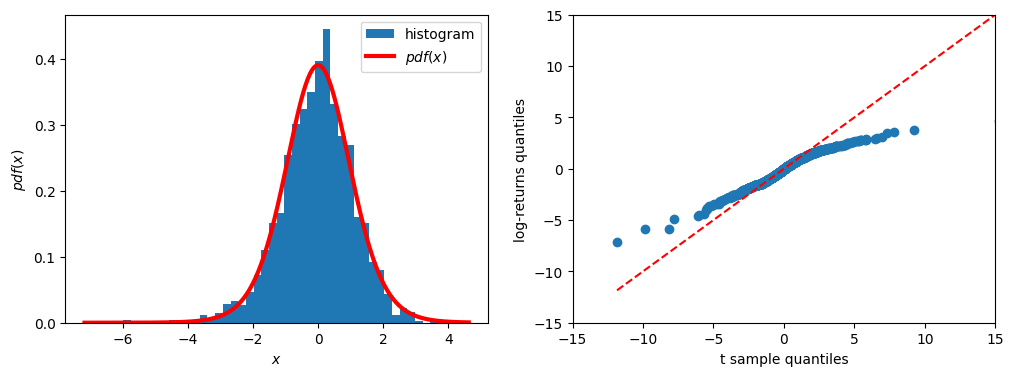

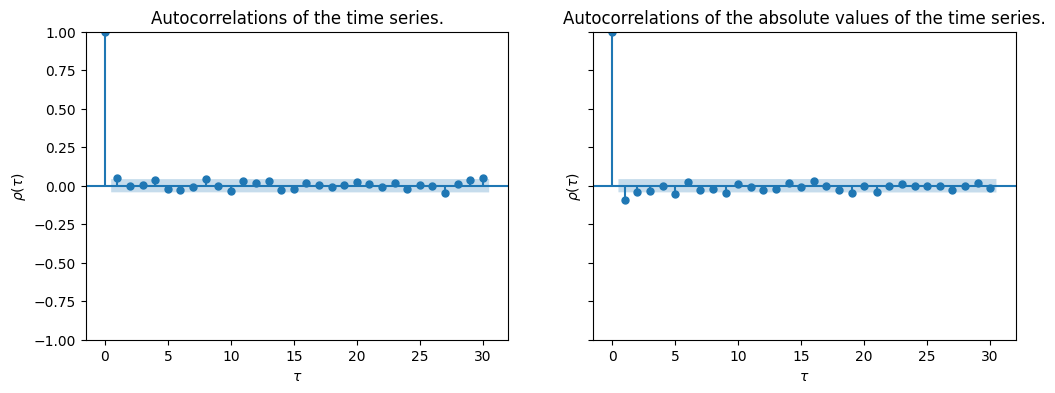

In [99]:
u_6, h_6 = residuals_ARMA_GARCH(
    log_returns,
    phi_0=phi_0_6,
    phi=phi_1_6,
    theta=[],
    kappa=kappa_6,
    alpha=alpha_6,
    beta=beta_6
)
epsilon_6 = u_6 / np.sqrt(h_6)

print(f'\n¿Media cero de los residuos? -> {np.mean(epsilon)}')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_histogram_pdf(
    epsilon_6,
    lambda x: stats.t.pdf(x, nu_6, 0.0, 1.0),
    n_bins=50,
    ax=axs[0],)

rng = default_rng(seed=2)
reference_sample = (stats.t.rvs(nu_6, size=(len(epsilon_6)), random_state=rng) * np.sqrt(h_6))

qqplot(reference_sample, epsilon_6, ax=axs[1])
_ = axs[1].set_xlabel('t sample quantiles')
_ = axs[1].set_ylabel('log-returns quantiles')
_ = axs[1].set_xlim(-15, 15)
_ = axs[1].set_ylim(-15, 15)


fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
_ = plot_acf(epsilon_6, lags=30, ax=axs[0]) # linear autocorrelations
_ = plot_acf(np.abs(epsilon_6), lags=30, ax=axs[1]) # non-linear dependencies
_ = axs[0].set_title('Autocorrelations of the time series.')
_ = axs[0].set_xlabel(r'$\tau$')
_ = axs[0].set_ylabel(r'$\rho(\tau)$')

_ = axs[1].set_title('Autocorrelations of the absolute values of the time series.')
_ = axs[1].set_xlabel(r'$\tau$')
_ = axs[1].set_ylabel(r'$\rho(\tau)$')

Observando los gráficos y lo que debería dar, parece que estamos ante el modelo correcto, por lo tanto la adición de restricciones y el cambio de optimizador permiten una mejora sustancial a lo planteado en primera instancia, ya que en mucho menos tiempo converge y con una solución mejor.

**Apartado 4**

**1.**

**Modelo con innovaciones Gaussianas:** los estimadores de maxima verosimilitud de los parámetros $\mu$ y $\sigma$ son la media y varianza muestral, respectivamente, por lo que $\mu$ es el rendimiento medio y $\sigma$ la desviación típica de los rendimientos.


In [ ]:
print(f'Media teórica: {np.round(mu_1, 5)}, Media serie: {np.round(np.mean(log_returns), 5)}')
print(f'Desv. Tip. teorica: {np.round(sigma_1, 5)}, Desv. Tip. serie: {np.round(np.std(log_returns), 5)}')

Media teórica: 0.00077, Media serie: 0.00077
Desv. Tip. teorica: 1.50668, Desv. Tip. serie: 1.50668


**Modelo con innovaciones $t$ de Student:** el parametro de localización, $\mu$, mide el centro de la distribución, que se corresponde con la media si $\nu$, los grados de libertad, es mayor que 2. El parámetro $\sigma$ mide la dispersión de los rendimientos. Ademas, los grados de libertad controlan el peso de las colas, a menor $\nu$, son mas pesadas.

Si $\nu > 2$ (si no, no estan definidas), la media de la serie se corresponde con $\mu$ y la varianza con $\sigma^2\frac{\nu}{\nu-2}$. Sin embargo, cuando tenemos pocos grados de libertad (entre 2 y 5), la disttribución $t$ de Student permite valores muy extremos con lo que media y varianza muestral son mas variables, por lo que vemos que los parámetros no coinciden exactamente con los datos empíricos.

In [ ]:
print(f'Grados de libertad: {np.round(nu_2, 5)}')
print(f'Media teórica: {np.round(location_2, 5)}, Media empírica: {np.round(np.mean(log_returns), 5)}')
print(f'Varianza teorica: {np.round(scale_2**2 * nu_2 /  (nu_2 - 2), 5)}, Varianza serie: {np.round(np.std(log_returns)**2, 5)}')

Grados de libertad: 2.90832
Media teórica: 0.0425, Media empírica: 0.00077
Varianza teorica: 2.8581, Varianza serie: 2.2701


**Modelo AR(1) con innovaciones Gaussianas:** los residuos son la parte no explicada por el modelo, por lo que se espera que tengan media cero. De lo contrario, habria una parte sistemática de los rendimientos no explicada por el modelo. El parámetro $\sigma$ mide en este caso la varianza no explicada por la dinamica autorregresiva. A mayor $\sigma$, menor predicibilidad del modelo. Se observa que la varianza de los residuos es muy ligeramente inferior a la varianza de los rendimientos, es decir, el modelo no es capaz de explicar la heterocedasticidad de los rendimientos.

In [ ]:
print(f'Media de los residuos es aproximadamente cero: {np.mean(u_3)}')
print(f'Desv. Tip. de los residuos: {np.round(np.std(u_3), 5)}')
print(f'Desv. Tip. de los rendimientos: {np.round(np.std(log_returns), 5)}')


Media de los residuos es aproximadamente cero: 1.9096551027725755e-06
Desv. Tip. de los residuos: 1.50582
Desv. Tip. de los rendimientos: 1.50668


**Modelo AR(1) con innovaciones $t$ de Student:** al igual que en el caso anterior, la media de los residuos debe ser cero. Por otro lado, a mayor valores de los parámetros $\nu$ y $\sigma$ de la $t$ de Student, mayor será la varianza de las innovaciones y, por tanto, menor capacidad predictiva del modelo respecto a la heterocedasticidad.
Sin embargo, observamos que la media de los residuos difiere de cero, por lo que existe una parte sistemática de los rendimientos no explicada por el modelo. Ademas la varianza de los rendimientos y de los residuos es practicamente la misma, por lo que el modelo no es capaz de explicar la volatilidad de los rendimientos.

In [ ]:
print(f'Media de los residuos: {np.round(np.mean(u_4), 5)}')
print(f'Parámetros que determinan la varianza: scale={np.round(scale_4, 5)}, grados de libertad={np.round(nu_4, 5)}')
print(f'Desv. Tip. serie: {np.round(np.std(log_returns), 5)}, Desv. Tip. residuos: {np.round(np.std(u_4), 5)}')

Media de los residuos: -0.04381
Parámetros que determinan la varianza: scale=0.94374, grados de libertad=2.90273
Desv. Tip. serie: 1.50668, Desv. Tip. residuos: 1.50608


**Modelo AR(1) + GARCH(1, 1) con innovaciones Gaussianas:** La introducción del modelo GARCH permite capturar la heterocedasticidad de los rendimientos, por lo que esperamos media cero de las innovaciones $\epsilon_t$ y una varianza pequeña, es decir $\epsilon_t \sim N(0, \sigma$ pequeña$)$. En ese caso $U_t \sim N(0, \sigma h_t)$. Observamos que $E[\epsilon_t] ≠ 0$ y $\sigma < std(R_t)$, por lo que este modelo si explica parte de la heterocedasticidad.

In [ ]:
print(f'Media de las innovaciones: {np.round(np.mean(epsilon_5), 5)}')
print(f'Desv. Tip. de las innovaciones: {np.round(np.std(epsilon_5), 5)}')
print(f'Desv. Tip. de los rendimientos: {np.round(np.std(log_returns), 5)}')

Media de las innovaciones: -0.03075
Desv. Tip. de las innovaciones: 0.98677
Desv. Tip. de los rendimientos: 1.50668


**Modelo AR(1) + GARCH(1,1) con innovaciones $t$ de Student:**

**2.**



In [ ]:
print('Grados de libertad')
print(f'Innovaciones t Student: {np.round(nu_2, 5)}')
print(f'AR(1) + Innovaciones t Student: {np.round(nu_4, 5)}')
print(f'AR(1) + GARCH(1,1) + Innovaciones t Student: {np.round(nu_6, 5)}')

Grados de libertad
Innovaciones t Student: 2.90832
AR(1) + Innovaciones t Student: 2.90273
AR(1) + GARCH(1,1) + Innovaciones t Student: 0.80855


Las diferencias en los grados de libertad reflejan cómo cada modelo logra capturar la naturaleza de los rendimientos extremos.

Estos valores indican diferencias relevantes en la forma de las colas de la distribución de los errores en cada modelo. En los dos primeros modelos, los grados de libertad cercanos a 3 sugieren colas pesadas, lo que implica una mayor probabilidad de observar rendimientos extremos en comparación con una distribución normal.

Sin embargo, en el modelo AR(1) + GARCH(1,1), el parámetro de grados de libertad estimado es cercano a 1, lo cual indica colas extremadamente pesadas. Esto sugiere que, a pesar de introducir el GARCH, los residuos del modelo siguen mostrando eventos extremos frecuentes.

**3.**

Ninguno de los modelos, tal y como se ha visto, captura la asimetría de los rendimientos ya que, en todos ellos, las innovaciones siguen una distribución simétrica, ya sea una normal o una $t$ de Student. Por tanto, para capturar esta anomalia, se debería formular un modelo cuyas innovaciones $U_t$ sigan una distribución con asimetria negativa, es decir, con un mayor riesgo de caidas fuertes que de subidas equivalentes. Por ejemplo, con la distribución de Jhonson SU, el modelo AR(1) + GARCH(1,1) quedaria tal que asi:

$R_t = \phi_0 + \phi_1 R_{t-1} + U_t$<br>
$U_t = \epsilon_t \sqrt(h_t)$ donde $\epsilon_t \sim J(\epsilon, λ, \gamma, δ)$<br>
La Jhonson SU esta definida como $\epsilon + \lambda sin(\frac{Z - \gamma}{\delta})$ donde $\gamma$ esta relacionado con la asimetria.
$h_t = \kappa + \alpha U_{t-1}^2 + \beta h_{t-1} $

**Bibliografía**
OpenAI. (2025). ChatGPT (May 24 version) [Large language model].
scipy.optimize.minimize help https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html